<a href="https://colab.research.google.com/github/alexanderwhatley/TCR-Pathogen-Identification/blob/master/analysis_vdjdb_tettcrseq_10x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install serializable
!pip install mhcflurry
!pip install ujson
!pip install pepdata
!pip install --no-cache-dir --force-reinstall --no-deps git+https://github.com/alexanderwhatley/pepnet
!pip install biopython 
!mhcflurry-downloads fetch models_class1
!pip install editdistance

  Cloning https://github.com/alexanderwhatley/pepnet to /tmp/pip-req-build-e7rb8oib
  Running command git clone -q https://github.com/alexanderwhatley/pepnet /tmp/pip-req-build-e7rb8oib
  Created wheel for pepnet: filename=pepnet-0.4.1-cp36-none-any.whl size=37931 sha256=c7fa5d8df9338033a17c1f6d4eb5d55c1af98ad6141c219d628c9309c1203afe
  Stored in directory: /tmp/pip-ephem-wheel-cache-_zlgdkut/wheels/b8/6e/41/54559f025ef55a43eea654be4192b90161726f6ecdd18c5fb5
Successfully built pepnet
  Found existing installation: pepnet 0.4.1
    Uninstalling pepnet-0.4.1:
      Successfully uninstalled pepnet-0.4.1


****************************************
The requested download 'models_class1' has already been downloaded. To re-download this data, first run: 
	rm -rf /root/.local/share/mhcflurry/4/1.4.0/models_class1/
in a shell and then re-run this command.
****************************************
Fetching 0/14 downloads from release 1.4.0
DOWNLOAD NAME                             ALREADY DOWNLOADED?    WILL DOWNLOAD NOW?    URL                  
models_class1_pan                         NO                     NO                    https://github.com/openvax/mhcflurry/releases/download/pre-1.4.0/models_class1_pan.20190928.tar.bz2 
models_class1_pan_unselected              NO                     NO                    https://github.com/openvax/mhcflurry/releases/download/pre-1.4.0/models_class1_pan_unselected.20190924.tar.bz2.part.aa 
data_iedb                                 NO                     NO                    https://github.com/openvax/mhcflurry/releases/download/pre-1.4.0/data_iedb.20

In [0]:
# Read in all necessary files 
import io
import os
from shutil import copyfile
from google.colab import drive
drive.mount('/content/gdrive')
    
def download_file(folder, name):
  copyfile("/content/gdrive/My Drive/TCR Epitope Identification/" + folder + "/" + name, name)

download_file('Literature Data', 'vdjdb_data.tsv')
download_file('Literature Data', 'HCV Data Combined.xlsx')
download_file('Literature Data', 'McPAS-TCR.csv')
download_file('Literature Data', 'Master Legend.xlsx')
download_file('Literature Data', 'Experiment 1.xlsx')
download_file('Literature Data', 'Experiment 2.xlsx')
download_file('Literature Data', 'Experiment 3.xlsx')
download_file('Literature Data', 'Experiment 4.xlsx')
download_file('Literature Data', 'Experiment 5.xlsx')
download_file('Literature Data', 'Experiment 6.xlsx')
download_file('Literature Data', 'vdj_v1_hs_aggregated_donor1_binarized_matrix.csv')
download_file('Literature Data', 'vdj_v1_hs_aggregated_donor2_binarized_matrix.csv')
download_file('Literature Data', 'vdj_v1_hs_aggregated_donor3_binarized_matrix.csv')
download_file('Literature Data', 'vdj_v1_hs_aggregated_donor4_binarized_matrix.csv')
download_file('UniProt Viral Sequences', 'uniprot-filtered-reviewed-human.fasta')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import copy
from collections import Counter, defaultdict
import itertools
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.spatial.distance import hamming 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, roc_curve, roc_auc_score, precision_recall_curve, accuracy_score, classification_report
import editdistance
from Bio.SubsMat.MatrixInfo import blosum62
from Bio import SeqIO
from pepnet.encoder import Encoder
from IPython.display import display, HTML
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, BatchNormalization, Flatten, concatenate, Lambda
import keras.backend as K

encoder = Encoder()
# amino acid properties 
aa_prop = pd.DataFrame(map(lambda x: x.split(","), "A,1.29,0.9,0,0.049,1.8,0,0,0.047,0.065,0.78,67,1,0,0,1,1;C,1.11,0.74,0,0.02,2.5,-2,0,0.015,0.015,0.8,86,1,1,-1,0,1;D,1.04,0.72,-1,0.051,-3.5,-2,1,0.071,0.074,1.41,91,1,0,1,1;E,1.44,0.75,-1,0.051,-3.5,-2,1,0.094,0.089,1,109,1,0,1,0,1;F,1.07,1.32,0,0.051,2.8,0,0,0.021,0.029,0.58,135,1,1,-1,0,1;G,0.56,0.92,0,0.06,-0.4,0,0,0.071,0.07,1.64,48,1,0,1,1,1;H,1.22,1.08,0,0.034,-3.2,1,1,0.022,0.025,0.69,118,1,0,-1,0,1;I,0.97,1.45,0,0.047,4.5,0,0,0.032,0.035,0.51,124,1,1,-1,0,1;K,1.23,0.77,1,0.05,-3.9,2,1,0.105,0.08,0.96,135,1,0,1,0,1;L,1.3,1.02,0,0.078,3.8,0,0,0.052,0.063,0.59,124,1,1,-1,1,1;M,1.47,0.97,0,0.027,1.9,0,0,0.017,0.016,0.39,124,1,1,1,0,1;N,0.9,0.76,0,0.058,-3.5,0,1,0.062,0.053,1.28,96,1,0,1,1,1;P,0.52,0.64,0,0.051,-1.6,0,0,0.052,0.054,1.91,90,1,0,1,0,1;Q,1.27,0.8,0,0.051,-3.5,1,1,0.053,0.051,0.97,114,1,0,1,0,1;R,0.96,0.99,1,0.066,-4.5,2,1,0.068,0.059,0.88,148,1,0,1,1,1;S,0.82,0.95,0,0.057,-0.8,-1,1,0.072,0.071,1.33,73,1,0,1,1,1;T,0.82,1.21,0,0.064,-0.7,-1,0,0.064,0.065,1.03,93,1,0,0,1,1;V,0.91,1.49,0,0.049,4.2,0,0,0.048,0.048,0.47,105,1,1,-1,0,1;W,0.99,1.14,0,0.022,-0.9,1,1,0.007,0.012,0.75,163,1,1,-1,0,1;Y,0.72,1.25,0,0.07,-1.3,-1,1,0.032,0.033,1.05,141,1,1,-1,1,1".split(";")), columns=['aminoacid', 'alpha', 'beta', 'charge', 'core', 'hydropathy', 'pH', 'polarity', 'rim', 'surface', 'turn', 'volume', 'count', 'strength', 'disorder', 'high_contact', 'count'], index=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])
aa_prop.drop(['aminoacid', 'count'], axis=1, inplace=True)
aa_prop = aa_prop.astype(float)
aa_prop_feats = aa_prop.shape[1]
aa_prop = {ind: row.values for ind, row in aa_prop.iterrows()}
# kidera properties
kidera = pd.DataFrame.from_records(list(map(lambda x: list(map(float, x.split(','))), "-1.56,-1.67,-0.97,-0.27,-0.93,-0.78,-0.2,-0.08,0.21,-0.48;0.22,1.27,1.37,1.87,-1.7,0.46,0.92,-0.39,0.23,0.93;1.14,-0.07,-0.12,0.81,0.18,0.37,-0.09,1.23,1.1,-1.73;0.58,-0.22,-1.58,0.81,-0.92,0.15,-1.52,0.47,0.76,0.7;0.12,-0.89,0.45,-1.05,-0.71,2.41,1.52,-0.69,1.13,1.1;-0.47,0.24,0.07,1.1,1.1,0.59,0.84,-0.71,-0.03,-2.33;-1.45,0.19,-1.61,1.17,-1.31,0.4,0.04,0.38,-0.35,-0.12;1.46,-1.96,-0.23,-0.16,0.1,-0.11,1.32,2.36,-1.66,0.46;-0.41,0.52,-0.28,0.28,1.61,1.01,-1.85,0.47,1.13,1.63;-0.73,-0.16,1.79,-0.77,-0.54,0.03,-0.83,0.51,0.66,-1.78;-1.04,0,-0.24,-1.1,-0.55,-2.05,0.96,-0.76,0.45,0.93;-0.34,0.82,-0.23,1.7,1.54,-1.62,1.15,-0.08,-0.48,0.6;-1.4,0.18,-0.42,-0.73,2,1.52,0.26,0.11,-1.27,0.27;-0.21,0.98,-0.36,-1.43,0.22,-0.81,0.67,1.1,1.71,-0.44;2.06,-0.33,-1.15,-0.75,0.88,-0.45,0.3,-2.3,0.74,-0.28;0.81,-1.08,0.16,0.42,-0.21,-0.43,-1.89,-1.15,-0.97,-0.23;0.26,-0.7,1.21,0.63,-0.1,0.21,0.24,-1.15,-0.56,0.19;0.3,2.1,-0.72,-1.57,-1.16,0.57,-0.48,-0.4,-2.3,-0.6;1.38,1.48,0.8,-0.56,0,-0.68,-0.31,1.03,-0.05,0.53;-0.74,-0.71,2.04,-0.4,0.5,-0.81,-1.07,0.06,-0.46,0.65".split(";"))), index=["A","R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V"], columns=list(map(lambda x: "f"+str(x), range(1,11))))
kidera_feats = kidera.shape[1]
kidera = {ind: row.values for ind, row in kidera.iterrows()}
# atchley properties 
atchley = pd.DataFrame(map(lambda x: x.split(','), "A,-0.591,-1.302,-0.733,1.570,-0.146;C,-1.343,0.465,-0.862,-1.020,-0.255;D,1.050,0.302,-3.656,-0.259,-3.242;E,1.357,-1.453,1.477,0.113,-0.837;F,-1.006,-0.590,1.891,-0.397,0.412;G,-0.384,1.652,1.330,1.045,2.064;H,0.336,-0.417,-1.673,-1.474,-0.078;I,-1.239,-0.547,2.131,0.393,0.816;K,1.831,-0.561,0.533,-0.277,1.648;L,-1.019,-0.987,-1.505,1.266,-0.912;M,-0.663,-1.524,2.219,-1.005,1.212;N,0.945,0.828,1.299,-0.169,0.933;P,0.189,2.081,-1.628,0.421,-1.392;Q,0.931,-0.179,-3.005,-0.503,-1.853;R,1.538,-0.055,1.502,0.440,2.897;S,-0.228,1.399,-4.760,0.670,-2.647;T,-0.032,0.326,2.213,0.908,1.313;V,-1.337,-0.279,-0.544,1.242,-1.262;W,-0.595,0.009,0.672,-2.128,-0.184;Y,0.260,0.830,3.097,-0.838,1.512".split(';')), columns=['aa', 'f0', 'f1', 'f2', 'f3', 'f4'])
atchley.set_index('aa', inplace=True)
atchley = atchley.astype(float)
atchley_feats = atchley.shape[1]
atchley = {ind: row.values for ind, row in atchley.iterrows()}
total_additional_properties = aa_prop_feats + kidera_feats + atchley_feats 

def encode_all_feats(peptides, max_peptide_length):
  # make encoding of blosum features, amino acid properties, kidera features, atchley features
  encoding = np.zeros((len(peptides), max_peptide_length, 20 + total_additional_properties))
  encoding[:, :, :20] = encoder.encode_onehot(peptides, max_peptide_length=max_peptide_length)[0]
  for pep_ind, peptide in enumerate(peptides):
    for ind, aa in enumerate(peptide):
      encoding[pep_ind, ind, 20:] = np.concatenate((aa_prop[aa], kidera[aa], atchley[aa]))
  return encoding 

## Read in VDJDB Data

In [0]:
# Build VDJDB model 
# Random Forest Model 

def get_vdjdb_data():
  vdjdb_data = pd.read_csv('vdjdb_data.tsv', sep='\t')
  vdjdb_data = vdjdb_data[(vdjdb_data['CDR3'].str.len() <= 20) & (vdjdb_data['Epitope'].str.len() <= 11)]
  return vdjdb_data 

def make_dataset_exclude_virus(vdjdb_data, virus='HCV'):
  # split data into training/validation by patient 
  vdjdb_data_filtered = vdjdb_data[vdjdb_data['Epitope species'] != virus] # exclude viral data (by default HCV)
  vdjdb_data_filtered = vdjdb_data_filtered[['CDR3', 'Epitope', 'Meta', 'Reference', 'Epitope species']] 
  vdjdb_data_filtered['Meta'] = vdjdb_data_filtered['Meta'].apply(lambda x: dict(json.loads(x)))
  vdjdb_data_filtered['Subject_ID'] = vdjdb_data_filtered['Meta'].apply(lambda x: x['subject.id'])
  num_blank_ids = vdjdb_data_filtered[vdjdb_data_filtered['Subject_ID'] == ''].shape[0]
  vdjdb_data_filtered.loc[vdjdb_data_filtered['Subject_ID'] == '', 'Subject_ID'] = ['Patient ' + str(i + 10**6) for i in range(num_blank_ids)]
  vdjdb_data_groupby = vdjdb_data_filtered.groupby(['Reference', 'Subject_ID']) # group corresponds to one patient 
  return vdjdb_data_groupby

def get_similarity_scores(peptides, cdrs):
  similarity_scores = []
  for i in range(len(peptides)):
    peptide, cdr3 = str(peptides[i]), str(cdrs[i])
    peptide = peptide + '-' * (11 - len(peptide))
    cdr3 = cdr3 + '-' * (20 - len(cdr3))
    ss = []
    for aa1 in peptide:
      for aa2 in cdr3:
        if aa1 == '-' and aa2 == '-':
          ss.append(1)
        elif aa1 == '-' or aa2 == '-':
          ss.append(-4)
        elif (aa1, aa2) in blosum62:
          ss.append(blosum62[(aa1, aa2)])
        else:
          ss.append(blosum62[(aa2, aa1)])
    similarity_scores.append(ss)
  return similarity_scores

def make_group_data(group):
  data, labels = [], []
  cdr3, peptides = [], []
  positive_cdr3 = encoder.encode_onehot(group['CDR3'].values, max_peptide_length=20)
  positive_epitopes = encoder.encode_onehot(group['Epitope'].values, max_peptide_length=11)
  combined_positive_peptides = np.hstack((positive_cdr3, positive_epitopes))
  cdr3.extend(group['CDR3'].tolist())
  peptides.extend(group['Epitope'].tolist())
  data.append(combined_positive_peptides.reshape((len(combined_positive_peptides), -1)))
  labels.extend(group.shape[0] * [1])
  binding_complex = set([(row['CDR3'], row['Epitope']) for _, row in group.iterrows()])
  cdr3_distinct, epitope_distinct = set(group['CDR3']), set(group['Epitope'])
  for epitope in epitope_distinct:
    for cdr3 in cdr3_distinct:
      if (cdr3, epitope) not in binding_complex:
        negative_cdr3 = encoder.encode_onehot([cdr3], max_peptide_length=20)[0]
        negative_epitope = encoder.encode_onehot([epitope], max_peptide_length=11)[0]
        combined_negative_peptide = np.concatenate((negative_cdr3, negative_epitope))
        data.append(combined_negative_peptide.reshape(1, -1))
        labels.append(0)

  return group['CDR3'].values, group['Epitope'].values, np.concatenate(data), np.array(labels)

def permute_patients(vdjdb_data_groupby):
  np.random.seed(42)
  prob_assigned = np.random.random(len(vdjdb_data_groupby))
  np.random.seed(42)
  train_data, train_labels, test_data, test_labels, train_patients, test_patients, \
  train_cdr3, test_cdr3, train_peptides, test_peptides = \
  [], [], [], [], [], [], [], [], [], []
  ctr = 0
  for ind, group in vdjdb_data_groupby:
    prob_assign = prob_assigned[ctr]
    ctr += 1
    positive_cdr3 = encoder.encode_onehot(group['CDR3'].values, max_peptide_length=20)
    positive_epitopes = encoder.encode_onehot(group['Epitope'].values, max_peptide_length=11)
    combined_positive_peptides = np.concatenate((positive_cdr3, positive_epitopes), axis=1)
    if prob_assign < 0.2:
      test_cdr3.extend(group['CDR3'].tolist())
      test_peptides.extend(group['Epitope'].tolist())
    else:
      train_cdr3.extend(group['CDR3'].tolist())
      train_peptides.extend(group['Epitope'].tolist())
    for i in range(len(combined_positive_peptides)):
      if prob_assign < 0.2:
        test_data.append(combined_positive_peptides[i].ravel())
        test_labels.append(1)
        test_patients.append(ind)
      else:
        train_data.append(combined_positive_peptides[i].ravel())
        train_labels.append(1)
        train_patients.append(ind)
    binding_complex = set([(row['CDR3'], row['Epitope']) for _, row in group.iterrows()])
    cdr3_distinct, epitope_distinct = set(group['CDR3']), set(group['Epitope'])
    if ind[1] != '':
      for epitope in epitope_distinct:
        for cdr3 in cdr3_distinct:
          if (cdr3, epitope) not in binding_complex:
            negative_cdr3 = encoder.encode_onehot([cdr3], max_peptide_length=20)[0]
            negative_epitope = encoder.encode_onehot([epitope], max_peptide_length=11)[0]
            combined_negative_peptide = np.concatenate((negative_cdr3, negative_epitope))
            if prob_assign < 0.2:
              test_data.append(combined_negative_peptide.ravel())
              test_labels.append(0)
              test_patients.append(ind)
              test_cdr3.append(cdr3)
              test_peptides.append(epitope)
            else:
              train_data.append(combined_negative_peptide.ravel())
              train_labels.append(0)
              train_patients.append(ind)
              train_cdr3.append(cdr3)
              train_peptides.append(epitope)
            
  return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels), \
         np.array(train_patients), np.array(test_patients), np.array(train_cdr3), np.array(test_cdr3), \
         np.array(train_peptides), np.array(test_peptides)

def permute_vdjdb_epitopes(vdjdb_data_groupby):
  vdjdb_data_groupby_epitopes = vdjdb_data_groupby.apply(lambda x: x)[['CDR3', 'Epitope']].groupby('Epitope')
  np.random.seed(42)
  prob_assigned = np.random.random(len(vdjdb_data_groupby_epitopes))
  np.random.seed(42)
  train_data, train_labels, test_data, test_labels, \
  train_cdr3, test_cdr3, train_peptides, test_peptides = \
  [], [], [], [], [], [], [], []
  ctr = 0
  for epitope, group in vdjdb_data_groupby_epitopes:
    prob_assign = prob_assigned[ctr]
    group_len = group.shape[0]
    ctr += 1
    positive_cdr3 = encoder.encode_onehot(group['CDR3'].values, max_peptide_length=20)
    positive_epitopes = encoder.encode_onehot([epitope] * group_len, max_peptide_length=11)
    combined_positive_peptides = np.concatenate((positive_cdr3, positive_epitopes), axis=1)
    if prob_assign < 0.2:
      test_cdr3.extend(group['CDR3'].tolist())
      test_peptides.extend(group['Epitope'].tolist())
    else:
      train_cdr3.extend(group['CDR3'].tolist())
      train_peptides.extend(group['Epitope'].tolist())
    for i in range(len(combined_positive_peptides)):
      if prob_assign < 0.2:
        test_data.append(combined_positive_peptides[i].ravel())
        test_labels.append(1)
      else:
        train_data.append(combined_positive_peptides[i].ravel())
        train_labels.append(1)
  ctr = 0
  train_peptides_set = set(train_peptides)
  for ind, group in vdjdb_data_groupby:
    binding_complex = set([(row['CDR3'], row['Epitope']) for _, row in group.iterrows()])
    cdr3_distinct, epitope_distinct = set(group['CDR3']), set(group['Epitope'])
    if ind[1] != '':
      for epitope in epitope_distinct:
        for cdr3 in cdr3_distinct:
          if (cdr3, epitope) not in binding_complex:
            negative_cdr3 = encoder.encode_onehot([cdr3], max_peptide_length=20)[0]
            negative_epitope = encoder.encode_onehot([epitope], max_peptide_length=11)[0]
            combined_negative_peptide = np.concatenate((negative_cdr3, negative_epitope))
            if epitope in train_peptides_set:
              train_data.append(combined_negative_peptide.ravel())
              train_labels.append(0)
              train_cdr3.append(cdr3)
              train_peptides.append(epitope)
            else:
              test_data.append(combined_negative_peptide.ravel())
              test_labels.append(0)
              test_cdr3.append(cdr3)
              test_peptides.append(epitope)             
            
  return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels), \
         np.array(train_cdr3), np.array(test_cdr3), np.array(train_peptides), np.array(test_peptides)

def augment_vdjdb_with_hs_epitopes(cdr3):
  '''
  VDJDB is imbalanced, with significantly more positives than negatives. We counter this by 
  augmenting it with additional epitope-CDR3 pairs consisting of epitopes from highly conserved 
  human proteins, which we assume are all negative. 
  '''
  human_peptide_affinities = pickle.load(open('/content/gdrive/My Drive/TCR Epitope Identification/human_peptide_affinities.pkl', 'rb'))
  np.random.seed(42)
  combined_df = pd.concat([human_peptide_affinities[allele] for allele in human_peptide_affinities])
  combined_df = combined_df[combined_df['prediction_percentile'] <= 2]
  print('Total number of sampled human conserved epitopes', combined_df.shape[0],'\n')
  indices = np.random.choice(combined_df.shape[0], size=len(cdr3))
  epitopes = combined_df['peptide'].values[indices]
  encoded_cdr3, encoded_epitopes = encoder.encode_onehot(cdr3), encoder.encode_onehot(epitopes)
  encoded_cdr3 = encoded_cdr3.reshape((len(encoded_cdr3), -1))
  encoded_epitopes = encoded_epitopes.reshape((len(encoded_epitopes), -1))
  data = np.hstack((encoded_cdr3, encoded_epitopes))
  
  return data, cdr3, epitopes

In [0]:
# read in data and process
vdjdb_data = get_vdjdb_data()
vdjdb_data_filtered = vdjdb_data[['CDR3', 'Epitope', 'Meta', 'Reference', 'Epitope species']] 
vdjdb_data_filtered['Meta'] = vdjdb_data_filtered['Meta'].apply(lambda x: dict(json.loads(x)))
vdjdb_data_filtered['Subject_ID'] = vdjdb_data_filtered['Meta'].apply(lambda x: x['subject.id'])
num_blank_ids = vdjdb_data_filtered[vdjdb_data_filtered['Subject_ID'] == ''].shape[0]
vdjdb_data_filtered.loc[vdjdb_data_filtered['Subject_ID'] == '', 'Subject_ID'] = ['Patient ' + str(i + 10**6) for i in range(num_blank_ids)]
vdjdb_data_groupby = vdjdb_data_filtered.groupby(['Reference', 'Subject_ID']) # group corresponds to one patient 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats 

In [0]:
# split into train/test data 
vdjdb_train_data, vdjdb_train_labels, vdjdb_test_data, vdjdb_test_labels, \
vdjdb_train_cdr3, vdjdb_test_cdr3, vdjdb_train_peptides, vdjdb_test_peptides = \
permute_vdjdb_epitopes(vdjdb_data_groupby)
print('VDJdb data before augmentation:')
print('Total number of data points', len(vdjdb_train_data) + len(vdjdb_test_data))
print('Total number of positives', sum(vdjdb_train_labels == 1) + sum(vdjdb_test_labels == 1))
print('Total number of negatives', sum(vdjdb_train_labels == 0) + sum(vdjdb_test_labels == 0))
print('Ratio of positives to negatives',(sum(vdjdb_train_labels == 1) + sum(vdjdb_test_labels == 1))/(sum(vdjdb_train_labels == 0) + sum(vdjdb_test_labels == 0)),'\n')

print('Train data:')
print('Total number of data points', len(vdjdb_train_data))
print('Ratio of positives to negatives',sum(vdjdb_train_labels == 1)/sum(vdjdb_train_labels == 0))
print('Distinct TCRs in train set', len(set(vdjdb_train_cdr3)))
print('Distinct epitopes in train set', len(set(vdjdb_train_peptides)),'\n')

print('Test data:')
print('Total number of data points', len(vdjdb_test_data))
print('Ratio of positives to negatives',sum(vdjdb_test_labels == 1)/sum(vdjdb_test_labels == 0))
print('Distinct TCRs in test set', len(set(vdjdb_test_cdr3)))
print('Distinct epitopes in test set', len(set(vdjdb_test_peptides)),'\n')

vdjdb_cdr3_peptide = set(zip(vdjdb_train_cdr3, vdjdb_train_peptides))
vdjdb_cdr3_set = set(vdjdb_train_cdr3)
vdjdb_peptides_set = set(vdjdb_train_peptides)

aug_train_data, aug_train_cdr3, aug_train_peptides = augment_vdjdb_with_hs_epitopes(vdjdb_train_cdr3)
augmented_vdjdb_train_data = np.concatenate((vdjdb_train_data, aug_train_data))
augmented_vdjdb_train_labels = np.concatenate((vdjdb_train_labels, np.zeros(len(aug_train_data))))

print('VDJdb data after augmentation:')
print('Train data:')
print('Total number of data points', len(augmented_vdjdb_train_data))
print('Ratio of positives to negatives',sum(augmented_vdjdb_train_labels == 1)/sum(augmented_vdjdb_train_labels == 0))
print('Distinct TCRs in train set', len(set(aug_train_cdr3)))
print('Distinct epitopes in train set', len(set(aug_train_peptides)),'\n')


VDJdb data before augmentation:
Total number of data points 23511
Total number of positives 18529
Total number of negatives 4982
Ratio of positives to negatives 3.719189080690486 

Train data:
Total number of data points 15407
Ratio of positives to negatives 3.1019701810436633
Distinct TCRs in train set 9216
Distinct epitopes in train set 86 

Test data:
Total number of data points 8104
Ratio of positives to negatives 5.610114192495922
Distinct TCRs in test set 7044
Distinct epitopes in test set 31 

Total number of sampled human conserved epitopes 338901 

VDJdb data after augmentation:
Train data:
Total number of data points 30814
Ratio of positives to negatives 0.6079945728748108
Distinct TCRs in train set 9216
Distinct epitopes in train set 14847 



## Read in TetTCR-Seq Data

In [0]:
# test combining VDJDB with TetraSeq
def clean_names(x):
  if x == 0 or pd.isnull(x):
    return x
  else:
    return x.replace('_', ' ').replace('-', ' ')

def prune_peptides(x, legend):
  if x == 0:
    return 0
  if x not in legend or pd.isnull(legend[x]):
    return 0
  x = legend[x]
  if len(x) > 11 or len(x) < 8:
    return 0
  return x
    

def process_experiment(file_name, legend_dict):
  print('Processing experiment', file_name)
  # process file and extract TCR-epitope data from it 
  legend = legend_dict[file_name]
  experiment = pd.read_excel(file_name + '.xlsx', skiprows=1)
  experiment = experiment[['Detected Peptide by MID Count', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 12']]
  experiment.columns = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5', 'CDR3']
  experiment = experiment.iloc[1:] # remove original column headers 
  experiment = experiment[experiment['CDR3'] != '']
  experiment = experiment[experiment['CDR3'].str.len() < 20]
  experiment[['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5']] = \
  experiment[['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5']].applymap(lambda x: clean_names(x))
  experiment[['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5']] = \
  experiment[['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5']].applymap(lambda x: prune_peptides(x, legend))
  distinct_peptides = set()
  for row in experiment[['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5']].values:
    for peptide in row:
      if peptide != 0:
        distinct_peptides.add(peptide)
  
  data = set()
  labels = []
  for _, row in experiment.iterrows():
    cdr3 = row['CDR3']
    peptides = []
    for peptide in row[['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5']]:
      if peptide != 0:
        peptides.append(peptide)
        if (cdr3, peptide) not in data:
          data.add((cdr3, peptide))
          labels.append(1)
    for peptide in distinct_peptides:
      if peptide not in peptides and ((cdr3, peptide) not in data):
        data.add((cdr3, peptide)) #Do any cdr3 sequences have multiple rows in one sheet?
        labels.append(0)
  
  encoded_data = []
  experiment_cdr3, experiment_peptides = [], []
  for cdr3, peptide in data:
    cdr3_encoded = encoder.encode_onehot([cdr3], max_peptide_length=20)[0].ravel()
    peptide_encoded = encoder.encode_onehot([peptide], max_peptide_length=11)[0].ravel()
    combined_encoded = np.concatenate((cdr3_encoded, peptide_encoded))
    encoded_data.append(combined_encoded)
    experiment_cdr3.append(cdr3)
    experiment_peptides.append(peptide)

  return np.array(encoded_data), np.array(labels), np.array(experiment_cdr3), np.array(experiment_peptides)

def process_all_experiments():
  master_legend = pd.read_excel('Master Legend.xlsx', skiprows=1)
  legend_dict = {}
  for i in range(6):
    experiment_cols = ['Experiment ' + str(i+1), 'Unnamed: ' + str(4*i+1), 'Unnamed: ' + str(4*i+2)]
    experiment_sub_df = master_legend[experiment_cols]
    experiment_sub_df.columns = ['Peptide Name', 'Sequence', 'Tetramer Fluorescence']
    experiment_sub_df = experiment_sub_df.iloc[1:]
    experiment_sub_df['Peptide Name'] = experiment_sub_df['Peptide Name'].apply(lambda x: clean_names(x))
    peptide_names = experiment_sub_df['Peptide Name'].values
    peptide_sequences = experiment_sub_df['Sequence'].values
    legend_dict['Experiment ' + str(i+1)] = dict(zip(peptide_names, peptide_sequences))

  experiment_dict = {}
  for i in range(6):
    experiment_dict['Experiment ' + str(i+1)] = process_experiment('Experiment ' + str(i+1), legend_dict)

  train_experiments = ['Experiment 1', 'Experiment 2', 'Experiment 3', 'Experiment 4', 'Experiment 5', 'Experiment 6']
  test_experiments = ['Experiment 5', 'Experiment 6']

  train_data = np.concatenate([experiment_dict[exp][0] for exp in train_experiments])
  test_data = np.concatenate([experiment_dict[exp][0] for exp in test_experiments])
  train_labels = np.concatenate([experiment_dict[exp][1] for exp in train_experiments])
  test_labels = np.concatenate([experiment_dict[exp][1] for exp in test_experiments])
  train_cdr3 = np.concatenate([experiment_dict[exp][2] for exp in train_experiments])
  test_cdr3 = np.concatenate([experiment_dict[exp][2] for exp in test_experiments])
  train_peptides = np.concatenate([experiment_dict[exp][3] for exp in train_experiments])
  test_peptides = np.concatenate([experiment_dict[exp][3] for exp in test_experiments])
  
  return train_data, test_data, train_labels, test_labels, train_cdr3, test_cdr3, train_peptides, test_peptides

tetraseq_train_data, tetraseq_test_data, tetraseq_train_labels, tetraseq_test_labels, \
tetraseq_train_cdr3, tetraseq_test_cdr3, tetraseq_train_peptides, tetraseq_test_peptides = process_all_experiments()

Processing experiment Experiment 1
Processing experiment Experiment 2
Processing experiment Experiment 3
Processing experiment Experiment 4
Processing experiment Experiment 5
Processing experiment Experiment 6


## Read in 10x Data

In [0]:
max_epitope_length=11
max_tcr_length=20

def tenx_readdata():
  ten_gen_data = []
  for i in range(1, 5):
    ten_gen_data.append(pd.read_csv('vdj_v1_hs_aggregated_donor{}_binarized_matrix.csv'.format(i)))
  ten_gen_data = pd.concat(ten_gen_data, ignore_index=True)
  print('Data shape (height, width):\n')
  print('ten_gen_data\n\t', ten_gen_data.shape)
  return ten_gen_data

def tenx_processdata(ten_gen_data, verbose=True):
  # Take 0/1 binding columns for each epitope
  data_cols = [col for col in ten_gen_data if col.endswith('_binder')]
  ten_gen_seq_df = ten_gen_data[data_cols].astype(int)
  ten_gen_seq_df = ten_gen_seq_df.rename(columns={col: col.split('_')[1] for col in ten_gen_seq_df.columns})
  if verbose:
    print('ten_gen_seq_df\n\t', ten_gen_seq_df.shape)
  # add a column with the sequenced CDR3
  ten_gen_seq_df['CDR3'] = ten_gen_data['cell_clono_cdr3_aa'].copy()
  # remove rows with no TRB CDR3 sequence
  ten_gen_seq_df = ten_gen_seq_df[ten_gen_seq_df['CDR3'].str.contains('TRB:')]
  if verbose:
    print('ten_gen_seq_df after adding CDR3 column and removing rows without TRB\n\t', ten_gen_seq_df.shape)
  # split CDR3 column into list of sequenced betas, dropping alpha information
  ten_gen_seq_df['CDR3'] = ten_gen_seq_df['CDR3'].apply(lambda x: [cdr3.strip('TRB:') for cdr3 in x.split(';') if 'TRB:' in cdr3])
  # Retain rows with exactly one TRB sequenced
  ten_gen_seq_df = ten_gen_seq_df.loc[np.array(list(map(len,ten_gen_seq_df.CDR3.values)))==1]
  ten_gen_seq_df['CDR3'] = ten_gen_seq_df['CDR3'].apply(lambda x:x[0]) # only have lists of length one now to back to string
  if verbose:
    print('ten_gen_seq_df after removing rows with multiple TRB sequenced\n\t', ten_gen_seq_df.shape)
  # Remove rows with CDR3s longer than our defined threshold
  ten_gen_seq_df = ten_gen_seq_df[ten_gen_seq_df['CDR3'].str.len() <= max_tcr_length]
  if verbose:
    print('ten_gen_seq_df after removing CDR3s longer than 20 AAs\n\t', ten_gen_seq_df.shape)
  # When the same CDR3 appears in multiple rows, aggregrate and take the 'mean' binding profile
  ten_gen_seq_df = ten_gen_seq_df.groupby('CDR3').agg(lambda x: np.rint(np.mean(x))).reset_index()
  if verbose:
    print('ten_gen_seq_df after grouping by CDR3 and taking mean binding profile\n\t', ten_gen_seq_df.shape)
  # count total positive bindings
  ten_gen_column_totals = ten_gen_seq_df[[col for col in ten_gen_seq_df if col != "CDR3"]].sum(axis=0)
  if verbose:
    print('\nTotal positive binding pairs after all processing', ten_gen_seq_df.shape[0])
  return(ten_gen_seq_df, ten_gen_column_totals)

ten_gen_data = tenx_readdata()
ten_gen_seq_df, ten_gen_column_totals = tenx_processdata(ten_gen_data)

Data shape (height, width):

ten_gen_data
	 (189512, 118)
ten_gen_seq_df
	 (189512, 50)
ten_gen_seq_df after adding CDR3 column and removing rows without TRB
	 (184443, 51)
ten_gen_seq_df after removing rows with multiple TRB sequenced
	 (174978, 51)
ten_gen_seq_df after removing CDR3s longer than 20 AAs
	 (174641, 51)
ten_gen_seq_df after grouping by CDR3 and taking mean binding profile
	 (63272, 51)

Total positive binding pairs after all processing 63272


In [0]:
def build_dataset(cdr3_seq, peptides_seq):
  all_cdr3, all_peptides = [], []
  for cdr3, peptide in itertools.product(cdr3_seq, peptides_seq):
    all_cdr3.append(cdr3)
    all_peptides.append(peptide)
  encoded_cdr3 = encoder.encode_onehot(all_cdr3, max_peptide_length=20).reshape((len(all_cdr3), -1))
  encoded_peptides = encoder.encode_onehot(all_peptides, max_peptide_length=11).reshape((len(all_peptides), -1))
  data = np.hstack((encoded_cdr3, encoded_peptides))
  return np.array(all_cdr3), np.array(all_peptides), data

dist_peptides = list(ten_gen_seq_df.columns)[1:]
ten_gen_all_cdr3, ten_gen_all_peptides, ten_gen_all_data = build_dataset(ten_gen_seq_df['CDR3'].values, dist_peptides)
ten_gen_all_labels = ten_gen_seq_df[dist_peptides].values.ravel()
one_ind = np.where(ten_gen_all_labels == 1)[0]
zero_ind = np.where(ten_gen_all_labels == 0)[0]
zero_ind_downsampled = np.random.choice(zero_ind, size=len(one_ind), replace=False)
downsampled_ind_set = set(list(zero_ind_downsampled))
zero_ind_other = [i for i in range(len(zero_ind)) if (i not in downsampled_ind_set)]
zero_ind_other = np.random.choice(zero_ind_other, size=50000, replace=False)
# downsample datasets 
print('Downsampling..')
ind = np.concatenate((zero_ind_downsampled, one_ind))
ten_gen_downsampled_data = ten_gen_all_data[ind]
ten_gen_downsampled_peptides = ten_gen_all_peptides[ind]
ten_gen_downsampled_cdr3 = ten_gen_all_cdr3[ind]
ten_gen_downsampled_labels = ten_gen_all_labels[ind]
# break downsampled data into train/test
print('Making train/test')
ten_gen_downsampled_train_data, ten_gen_downsampled_test_data, ten_gen_downsampled_train_labels, ten_gen_downsampled_test_labels \
= train_test_split(ten_gen_downsampled_data, ten_gen_downsampled_labels, test_size=0.2)

Downsampling..
Making train/test


Confusion matrix 10x
 [[2477  148]
 [ 189 2474]]
Sensitivity 0.9436190476190476 Specificity 0.9290274126924521


Text(0, 0.5, 'Recall')

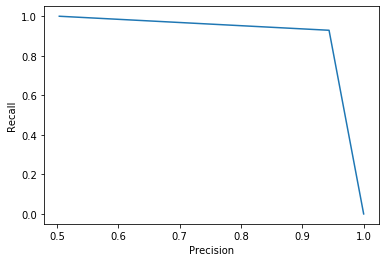

In [0]:
# test 10x classifier 
clf_ten_gen = RandomForestClassifier()
clf_ten_gen.fit(ten_gen_downsampled_train_data, ten_gen_downsampled_train_labels)
preds = clf_ten_gen.predict(ten_gen_downsampled_test_data)
cm = confusion_matrix(ten_gen_downsampled_test_labels, preds)
print('Confusion matrix 10x\n', cm)
print('Sensitivity', cm[0,0]/(cm[0,0]+cm[0,1]), 'Specificity', cm[1,1]/(cm[1,0]+cm[1,1]))
precision, recall, thresholds = precision_recall_curve(ten_gen_downsampled_test_labels, preds)
plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')

In [0]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, BatchNormalization, Flatten, concatenate, Lambda
import keras.backend as K
from keras.layers import (
    Input,
    Embedding,
    Dropout,
    Conv1D,
    Lambda,
    GlobalAveragePooling1D,
    GlobalMaxPooling1D,
    Concatenate,
    SpatialDropout1D,
    Dense,
    Activation,
    BatchNormalization,
    Concatenate,
    Reshape,
    Multiply,
    Add,
    Dot,
    Flatten,
    Lambda,
    LSTM,
    GRU,
    Bidirectional
)
from keras.layers.wrappers import TimeDistributed
import keras.initializers
from tensorflow import debugging 

def l2_norm(x, axis=None):
    """
    takes an input tensor and returns the l2 norm along specified axis
    """

    square_sum = K.sum(K.square(x), axis=axis, keepdims=True)
    norm = K.sqrt(K.maximum(square_sum, K.epsilon()))

    return norm

def pairwise_cosine_sim(A_B):
    """
    A [batch x n x d] tensor of n rows with d dimensions
    B [batch x m x d] tensor of n rows with d dimensions

    returns:
    D [batch x n x m] tensor of cosine similarity scores between each point i<n, j<m
    """

    A, B = A_B
    A_mag = l2_norm(A, axis=2)
    B_mag = l2_norm(B, axis=2)
    num = K.batch_dot(A, K.permute_dimensions(B, (0,2,1)))
    den = (A_mag * K.permute_dimensions(B_mag, (0,2,1)))
    dist_mat =  num / den

    return dist_mat
  
def masked_mse(y_true, y_pred):
    mask = debugging.is_nan(y_true)
    diff = y_pred - y_true
    squared = K.square(diff)
    sum_squared_error = K.sum(
        K.switch(mask, K.zeros(K.shape(squared)), squared),
        axis=-1)
    n_valid_per_sample = K.sum(K.cast(~mask, dtype='float32'), axis=-1)
    return sum_squared_error / n_valid_per_sample

def nn_v1():
  # convolutional layer for peptide data 
  peptide_input = Input(shape=(11, 21))
  conv_peptide = Conv1D(5, 5, activation='relu')(peptide_input)
  conv_peptide = BatchNormalization()(conv_peptide)

  # convolutional layer for CDR3 data 
  cdr3_input = Input(shape=(20, 21))
  conv_cdr3 = Conv1D(5, 5, activation='relu')(cdr3_input)
  conv_cdr3 = BatchNormalization()(conv_cdr3)

  # average/max pooling layers for peptide and CDR3
  max_pool_peptide = GlobalMaxPooling1D()(conv_peptide)
  avg_pool_peptide = GlobalAveragePooling1D()(conv_peptide)
  max_pool_cdr3 = GlobalMaxPooling1D()(conv_cdr3)
  avg_pool_cdr3 = GlobalAveragePooling1D()(conv_cdr3)

  # lstm layers
  lstm_peptide = LSTM(5)(conv_peptide)
  lstm_cdr3 = LSTM(5)(conv_cdr3)

  # cosine similarity between peptide and CDR3 convolution layer
  cosine_sim = Lambda(pairwise_cosine_sim)([conv_peptide, conv_cdr3])
  cosine_sim = Flatten()(cosine_sim)

  # merge average/max pooling, LSTM, and cosine similarity layers and feed into dense layers 
  merged_layers = Concatenate()([max_pool_peptide, avg_pool_peptide, lstm_peptide, cosine_sim, lstm_cdr3, avg_pool_cdr3, max_pool_cdr3])
  dense_layer = Dense(20, activation='relu')(merged_layers)
  dense_layer = BatchNormalization()(dense_layer)
  output_layer = Dense(1, activation='sigmoid')(dense_layer)

  model = Model(inputs=[peptide_input, cdr3_input], outputs=[output_layer])
  model.compile('adam', loss=masked_mse, metrics=['accuracy'])
  return model 

In [0]:
model = nn_v1()
train_cdr3 = encoder.encode_onehot(ten_gen_downsampled_cdr3, max_peptide_length=20)
train_peptides = encoder.encode_onehot(ten_gen_downsampled_peptides, max_peptide_length=11)
model.fit([train_peptides, train_cdr3], ten_gen_downsampled_labels, epochs=10, batch_size=128)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





26436/26436 [==============================] - 7s 272us/step - loss: 0.0890 - acc: 0.8819
Epoch 2/10
26436/26436 [==============================] - 5s 179us/step - loss: 0.0521 - acc: 0.9286
Epoch 3/10
26436/26436 [==============================] - 5s 180us/step - loss: 0.0500 - acc: 0.9318
Epoch 4/10
26436/26436 [==============================] - 5s 180us/step - loss: 0.0485 - acc: 0.9344
Epoch 5/10
26436/26436 [==============================] - 5s 182us/step - loss: 0.0476 - acc: 0.9352
Epoch 6/10
26436/26436 [==============================] - 5s 181us/step - loss: 0.0467 - acc: 0.9379
Epoch 7/10
26436/26436 [==============================] - 5s 180us/step - loss: 0.0457 - acc: 0.9395
Epoch 8/10
26436/26436 [==============================] - 5s 182us/step - loss: 0.0447 - acc: 0.9416
Epoch 9/10
26436/26436 [==============================] - 5s 187us/step - loss: 0.044

## See how well 10x model works on overlapping epitopes 

In [0]:
# test 10x model on overlapping epitope samples from VDJDB 
# unfortunately 'KLGGALQAK', 'AVFDRKSDAK' are not in VDJDB so I'm not sure if we can get meaningful results here...
#epitope_vdjdb_10x = list(set(ten_gen_train_peptides).intersection(vdjdb_train_peptides))
epitope_vdjdb_10x = ['GILGFVFTL', 'ELAGIGILTV']
data_ind = [i for i in range(len(vdjdb_train_peptides)) if vdjdb_train_peptides[i] in epitope_vdjdb_10x]
common_peptides = vdjdb_train_peptides[data_ind]
common_cdr3 = vdjdb_train_cdr3[data_ind]
encoded_common_cdr3 = encoder.encode_onehot(common_cdr3, max_peptide_length=20)
encoded_common_peptides = encoder.encode_onehot(common_peptides, max_peptide_length=11)
common_data_vdjdb = np.hstack((encoded_common_cdr3.reshape((len(common_cdr3), -1)), encoded_common_peptides.reshape((len(common_peptides), -1))))
common_labels_vdjdb = vdjdb_train_labels[data_ind]
preds_vdjdb = clf_ten_gen.predict(common_data_vdjdb)
cm = confusion_matrix(common_labels_vdjdb, preds_vdjdb)
print('Confusion matrix 10x\n', cm)
print('Sensitivity', cm[0,0]/(cm[0,0]+cm[0,1]), 'Specificity', cm[1,1]/(cm[1,0]+cm[1,1]))
preds_vdjdb = np.rint(model.predict([encoded_common_peptides, encoded_common_cdr3]))
cm = confusion_matrix(common_labels_vdjdb, preds_vdjdb)
print('Confusion matrix 10x\n', cm)
print('Sensitivity', cm[0,0]/(cm[0,0]+cm[0,1]), 'Specificity', cm[1,1]/(cm[1,0]+cm[1,1]))

In [0]:
# check quality scores of these samples 
vdjdb_data = get_vdjdb_data()
vdjdb_data = vdjdb_data[vdjdb_data['Epitope'].isin(epitope_vdjdb_10x)]
quality_score = vdjdb_data['Score']
plt.hist(quality_score)

In [0]:
# see classifiers accuracy on each set of samples 
cdr3_epitope = vdjdb_data[['CDR3', 'Epitope']].values
quality_score = vdjdb_data['Score'].values 
encoded_common_cdr3 = encoder.encode_onehot(cdr3_epitope[:, 0], max_peptide_length=20).reshape((len(cdr3_epitope), -1))
encoded_common_peptides = encoder.encode_onehot(cdr3_epitope[:, 1], max_peptide_length=11).reshape((len(cdr3_epitope), -1))
common_data_vdjdb = np.hstack((encoded_common_cdr3, encoded_common_peptides))
for i in range(3+1):
  ind = np.where(quality_score == i)[0]
  if len(ind) == 0:
    print('No samples with Quality =', i)
    continue
  quality_data = common_data_vdjdb[ind]
  preds_quality = clf_ten_gen.predict(quality_data)
  print('Quality =', i, 'Accuracy =', accuracy_score(np.ones(len(preds_quality)), preds_quality))

In [0]:
# test 10x model on overlapping epitope samples from TetTCR-Seq  
#epitope_tetraseq_10x = list(set(ten_gen_train_peptides).intersection(tetraseq_train_peptides))
epitope_tetraseq_10x = ['GILGFVFTL', 'ELAGIGILTV']
data_ind = [i for i in range(len(tetraseq_train_peptides)) if tetraseq_train_peptides[i] in epitope_tetraseq_10x]
common_peptides = tetraseq_train_peptides[data_ind]
common_cdr3 = tetraseq_train_cdr3[data_ind]
encoded_common_cdr3 = encoder.encode_onehot(common_cdr3, max_peptide_length=20)
encoded_common_peptides = encoder.encode_onehot(common_peptides, max_peptide_length=11)
common_data_tetraseq = np.hstack((encoded_common_cdr3.reshape((len(common_cdr3), -1)), encoded_common_peptides.reshape((len(common_peptides), -1))))
common_labels_tetraseq = tetraseq_train_labels[data_ind]
preds_tetraseq = clf_ten_gen.predict(common_data_tetraseq)
cm = confusion_matrix(common_labels_tetraseq, preds_tetraseq)
print('Confusion matrix 10x\n', cm)
print('Sensitivity', cm[0,0]/(cm[0,0]+cm[0,1]), 'Specificity', cm[1,1]/(cm[1,0]+cm[1,1]))
preds_vdjdb = np.rint(model.predict([encoded_common_peptides, encoded_common_cdr3]))
cm = confusion_matrix(common_labels_tetraseq, preds_vdjdb)
print('Confusion matrix 10x\n', cm)
print('Sensitivity', cm[0,0]/(cm[0,0]+cm[0,1]), 'Specificity', cm[1,1]/(cm[1,0]+cm[1,1]))

In [0]:
# test the model on high quality epitopes from VDJDB 
min_distances = {epitope: min(editdistance.eval(epitope, peptide) for peptide in dist_peptides) for epitope in vdjdb_data['Epitope'].unique()}
cms_byscore = list()
for score in [1, 2, 3]:
  vdjdb_data = get_vdjdb_data()
  high_quality_vdjdb = vdjdb_data[vdjdb_data['Score'] == score]
  high_quality_cdr3 = encoder.encode_onehot(high_quality_vdjdb['CDR3'].values, max_peptide_length=20)
  high_quality_peptides = encoder.encode_onehot(high_quality_vdjdb['Epitope'].values, max_peptide_length=11)
  preds_high_quality = np.rint(model.predict([high_quality_peptides, high_quality_cdr3]))
  cm = confusion_matrix(np.ones(len(preds_high_quality)), preds_high_quality)
  print('Confusion matrix for Score', score)
  print(cm)
  sens = cm[1,1]/(cm[1,1]+cm[1,0])
  print('sensitivity =', sens)
  cms_byscore.append(cm)
  min_edit_distance = np.array(list(map(min_distances.get, high_quality_vdjdb['Epitope'].values)))
  plt.hist(min_edit_distance[np.where(preds_high_quality == 1)[0]], alpha=0.5, label='Correct Predictions')
  plt.hist(min_edit_distance[np.where(preds_high_quality == 0)[0]], alpha=0.5, label='Incorrect Predictions')
  plt.legend()
  plt.show()
  df_results = pd.DataFrame({'Epitope': high_quality_vdjdb['Epitope'].values, 'CDR3': high_quality_vdjdb['CDR3'].values, 
                             'Prediction Correct': (preds_high_quality == 1).ravel(), 
                             'Epitope Min Edit Distance From 10x': min_edit_distance})
  df_results.sort_values('Prediction Correct', inplace=True)
  # with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    # display(df_results)


fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
xtp = [1,2,3]; ytp = [cm[1,1]/(cm[1,1]+cm[1,0]) for cm in cms_byscore]
ax.scatter(xtp,ytp, color='k')
ax.set_ylabel('sensitivity')
ax.set_xlabel('VDJDB quality score')
ax.set_xticks(xtp)
plt.tight_layout()

In [0]:
# test the model on entire TetTCR-Seq 
encoded_cdr3 = encoder.encode_onehot(tetraseq_train_cdr3, max_peptide_length=20)
encoded_peptides = encoder.encode_onehot(tetraseq_train_peptides, max_peptide_length=11)
preds_tettcrseq = np.rint(model.predict([encoded_peptides, encoded_cdr3]))
cm = confusion_matrix(tetraseq_train_labels, preds_tettcrseq)
print('Confusion matrix 10x\n', cm)
print('Sensitivity', cm[0,0]/(cm[0,0]+cm[0,1]), 'Specificity', cm[1,1]/(cm[1,0]+cm[1,1]))

## Step 2 Process

In [0]:
# read in data 
from collections import defaultdict
import itertools
import os
import pickle
from Bio import SeqIO
from mhcflurry import Class1AffinityPredictor
import pandas as pd

# functions that predict probability of binding given the (CDR3, Epitope) combinations 
def rf_proba(x, clf_rf):
  if len(x) == 0:
    return np.array([])
  encoded_data = []
  for tcr, epitope in x:
    encoded_data.append(encode_data(tcr, epitope))
  encoded_data = np.array(encoded_data)
  bind_pred = clf_rf.predict_proba(encoded_data)[:, 1]
  return bind_pred

def nn_proba(x, nn):
  if len(x) == 0:
    return np.array([])
  encoded_cdr3, encoded_peptides = [], []
  for tcr, epitope in x:
    encoded_cdr3.append(tcr)
    encoded_peptides.append(epitope)
  encoded_cdr3, encoded_peptides = \
  encoder.encode_onehot(encoded_cdr3, max_peptide_length=20), encoder.encode_onehot(encoded_peptides, max_peptide_length=11)
  bind_pred = nn.predict([encoded_peptides, encoded_cdr3]).ravel()
  return bind_pred  

# read in data from vdjdb 
vdjdb_data = pd.read_csv('vdjdb_data.tsv', sep='\t')
vdjdb_data = vdjdb_data[['CDR3', 'Epitope', 'Meta', 'Reference', 'MHC A']]
vdjdb_data = vdjdb_data[(vdjdb_data['CDR3'].str.len() <= 20) & 
                    (vdjdb_data['Epitope'].str.len() <= 11)]
mhc_alleles = vdjdb_data['MHC A'].unique()

# make predictions, using MHC alleles from vdjdb 
predictor = Class1AffinityPredictor.load()

virus_types = ['HIV', 'HPV', 'Influenza', 'Japanese Encephalitis Virus', 'HHV8', 'Hepatitis A', 
               'Hepatitis B', 'Hepatitis C', 'Hepatitis E', 'Measles', 'Rotavirus', 'Norovirus', 
               'RSV', 'Dengue Virus', 'Yellow Fever Virus', 'Zika', 'Zaire Ebolavirus', 'West Nile Virus',
               'Varicella-zoster', 'SARS', 'Rubella', 'Rabies', 'Poliovirus', 'Parvovirus B19', 'Mumps', 
               'Marburg', 'Human adenovirus 11', 'Coxsackievirus A16', 'Chikungunya', 'HHV1', 'HHV5', 
               'Influenza H1N1', 'Influenza H2N2', 'Influenza H3N2', 'Influenza H5N1', 'Influenza H7N9']
def get_peptides(proteins, lengths=[8, 9, 10, 11]):
  virus_peptides = set()
  for length in lengths:
    for protein in proteins:
      for i in range(len(protein)-length):
        peptide = protein[i:i+length]
        virus_peptides.add(peptide)
        
  return list(virus_peptides) 

def process_mhc_alleles(mhc_alleles):
  processed = []
  for allele in mhc_alleles:
    split = allele.split(':')
    if len(split) >= 3:
      split = split[:2]
      allele = ':'.join(split)
    if 'HLA-A' in allele or 'HLA-B' in allele or 'HLA-C' in allele:
      processed.append(allele)
  return processed

virus_peptides = {}
peptide_to_virus = defaultdict(list)
for virus in virus_types:
  proteins = [str(seq_record.seq) for seq_record in 
              SeqIO.parse('/content/gdrive/My Drive/TCR Epitope Identification/UniProt Viral Sequences/' + virus + ".fasta", "fasta")]
  print(virus, sum(len(seq) for seq in proteins))
  virus_peptides[virus] = get_peptides(proteins)
  for peptide in virus_peptides[virus]:
    peptide_to_virus[peptide].append(virus)
pickle.dump(peptide_to_virus, open('/content/gdrive/My Drive/TCR Epitope Identification/peptide_to_virus.pkl', 'wb'))

print('Processing peptides...')
all_peptides = set()
for virus in virus_peptides:
  all_peptides = all_peptides.union(set(virus_peptides[virus]))
all_peptides = list(all_peptides)

def get_affinities(mhc_alleles):
  supported_alleles = set(predictor.supported_alleles)
  alleles_to_predict = set(process_mhc_alleles(mhc_alleles))
  allele_intersection = supported_alleles.intersection(alleles_to_predict)
  epitope_affinities = {}
  for allele in allele_intersection:
    print('Prediction finished for allele', allele)
    epitope_affinities[allele] = predictor.predict_to_dataframe(allele=allele, peptides=all_peptides)
    
  return epitope_affinities

HIV 3568
HPV 2652
Influenza 4557
Japanese Encephalitis Virus 4630
HHV8 38454
Hepatitis A 2227
Hepatitis B 1792
Hepatitis C 3173
Hepatitis E 2467
Measles 5202
Rotavirus 923
Norovirus 2507
RSV 3557
Dengue Virus 3392
Yellow Fever Virus 3411
Zika 3419
Zaire Ebolavirus 5494
West Nile Virus 3433
Varicella-zoster 35782
SARS 14377
Rubella 3179
Rabies 3615
Poliovirus 2209
Parvovirus B19 1701
Mumps 4977
Marburg 4873
Human adenovirus 11 10948
Coxsackievirus A16 2193
Chikungunya 4546
HHV1 37285
HHV5 61704
Influenza H1N1 5298
Influenza H2N2 10380
Influenza H3N2 2419
Influenza H5N1 5317
Influenza H7N9 4784
Processing peptides...


In [0]:
# generate binding scores for all epitopes that can be generated in this dataset 
#HCV_tcr_data = vdjdb_data[vdjdb_data['Reference'] == 'PMID:28146579']
HCV_tcr_data = vdjdb_data[vdjdb_data['Reference'] == 'PMID:27252176'] 
HCV_tcr_data['Patient'] = HCV_tcr_data['Meta'].apply(lambda x: json.loads(x)['subject.id'])

#HCV_tcr_data = pd.read_excel('HCV Data Combined.xlsx')
HCV_tcr_data_groupby = HCV_tcr_data.groupby('Patient')
patient_tcr = []
alleles_by_patient = []
mhc_alleles = set()
for _, group in HCV_tcr_data_groupby:
  patient_tcr.append(group['CDR3'].tolist())
  #patient_alleles = group['HLA Class I'].values[0].split(', ')
  patient_alleles = group['MHC A'].tolist()
  alleles_by_patient.append(patient_alleles)
  mhc_alleles.update(patient_alleles)
mhc_alleles = list(mhc_alleles)


if not os.path.isfile('/content/gdrive/My Drive/TCR Epitope Identification/epitope_affinities_HCV.pkl'):  
  epitope_affinities = get_affinities(mhc_alleles)
  pickle.dump(epitope_affinities, open('/content/gdrive/My Drive/TCR Epitope Identification/epitope_affinities_HCV.pkl', 'wb'))
else:
  epitope_affinities = pickle.load(open('/content/gdrive/My Drive/TCR Epitope Identification/epitope_affinities_HCV.pkl', 'rb'))

'''
epitope_affinities = get_affinities(mhc_alleles)
pickle.dump(epitope_affinities, open('/content/gdrive/My Drive/TCR Epitope Identification/epitope_affinities_HCV.pkl', 'wb'))
'''

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


"\nepitope_affinities = get_affinities(mhc_alleles)\npickle.dump(epitope_affinities, open('/content/gdrive/My Drive/TCR Epitope Identification/epitope_affinities_HCV.pkl', 'wb'))\n"

In [0]:
pd.set_option('display.max_rows', None)
display(vdjdb_data_groupby.apply(lambda x: (x.shape[0], x['Epitope species'])))

Reference                                            Subject_ID         
PMID:10435578                                        Patient 1000035                         (1, [HTLV-1])
                                                     Patient 1000036                         (1, [HTLV-1])
                                                     Patient 1000037                         (1, [HTLV-1])
                                                     Patient 1006648                         (1, [HTLV-1])
                                                     Patient 1006649                         (1, [HTLV-1])
                                                     Patient 1006650                         (1, [HTLV-1])
PMID:10756006                                        donor C                                   (11, [CMV])
PMID:10925283                                        PBL1                                      (11, [EBV])
                                                     PBL2              

In [0]:
select_experiments_filtered = vdjdb_data_groupby.apply(lambda x: (x.shape[0], x['Epitope species']))
select_experiments_filtered = select_experiments_filtered.to_frame(name='Counts')
select_experiments_filtered = select_experiments_filtered[select_experiments_filtered['Counts'].apply(lambda x: x[0] >= 5)]
pd.set_option('display.max_rows', None)
display(select_experiments_filtered)

Counts
Reference                                          Subject_ID                                    
PMID:10756006                                      donor C                            (11, [CMV])
PMID:10925283                                      PBL1                               (11, [EBV])
                                                   PBL2                                (5, [EBV])
                                                   PBL4                                (5, [EBV])
                                                   RA1                                 (7, [EBV])
PMID:11046006                                      IM61                               (30, [EBV])
                                                   IM69                               (33, [EBV])
                                                   IM74                               (23, [EBV])
PMID:12504586                                      E1                                 (16, [EBV])
                                                   E2                                 (14, [EBV])
                                                   E3                                 (26, [EBV])
PMID:12555663                                      M138                       (10, [HomoSapiens])
                                                   M180                       (24, [HomoSapiens])
                                                   M199                       (16, [HomoSapiens])
                                                   PBL1                                (8, [EBV])
                                                   PBL2                                (6, [EBV])
                                                   VER                        (54, [HomoSapiens])
PMID:15596521                                      005                               (8, [HIV-1])
                                                   046                              (10, [HIV-1])
                                                   200                               (8, [HIV-1])
PMID:15753288                                      202-T07                          (31, [HIV-1])
                                                   2714A                             (6, [HIV-1])
PMID:16148129                                      DY                                 (14, [EBV])
                                                   EL                                  (9, [EBV])
                                                   GB                                  (5, [EBV])
PMID:16237109                                      HD5                                (10, [CMV])
                                                   RA11                                (6, [CMV])
PMID:16772368                                      AC-06                             (6, [HIV-1])
                                                   AC-132                           (10, [HIV-1])
                                                   AC-15                            (10, [HIV-1])
                                                   AC-88                             (5, [HIV-1])
PMID:16982909                                      PB-001                            (6, [HIV-1])
                                                   SK-006                            (5, [HIV-1])
                                                   SK-113                           (10, [HIV-1])
                                                   SK-197                           (14, [HIV-1])
                                                   SK-235                            (8, [HIV-1])
PMID:17121793                                      020018                            (5, [HIV-1])
                                                   100089                            (6, [HIV-1])
                                                   AC-121                            (9, [HIV-1])
                                                   AC-167                

In [0]:
from IPython.display import display, HTML
from scipy.stats import binom_test 

human_peptide_affinities = pickle.load(open('/content/gdrive/My Drive/TCR Epitope Identification/human_peptide_affinities.pkl', 'rb'))

def encode_data(tcr, epitope):
  epitope = epitope.replace('X', 'A')
  tcr = tcr.replace('*', 'A')
  cdr_encoded = encoder.encode_blosum([tcr], max_peptide_length=20)[0]
  epitope_encoded = encoder.encode_blosum([epitope], max_peptide_length=11)[0]
  combined_encoded = np.concatenate((cdr_encoded, epitope_encoded))
  combined_encoded = combined_encoded.ravel()
  return combined_encoded

def get_binding_epitopes(tcrs, patient_alleles, cutoff):
  combined_epitope_df = pd.concat([epitope_affinities[allele] for allele in epitope_affinities])
  binding_epitopes = combined_epitope_df[combined_epitope_df['prediction_percentile'] <= cutoff]
  patient_binding_epitopes = binding_epitopes['peptide'].unique()
  return patient_binding_epitopes

def make_dataframe(tcrs, virus_binding_peptides, predicted_to_bind_by_virus, cutoffs, background_rate):
  data = []
  for virus in virus_types:
    data.append({'Virus': virus, 'TCRs': len(tcrs), 'Binding Epitopes': len(virus_binding_peptides[virus]),
                 'TCR/Epitope Complexes': len(tcrs) * len(virus_binding_peptides[virus]), 
                 'Binding Prediction': predicted_to_bind_by_virus[virus], 
                 'Background Prediction': background_rate * len(tcrs) * len(virus_binding_peptides[virus])})
  data = pd.DataFrame(data)
  data['Enrichment'] = data['Binding Prediction'] / data['Background Prediction']
  data['Cutoff'] = cutoffs
  # perform a binomial test for each virus 
  data['Binomial test p-value'] = data[['Binding Prediction', 'TCR/Epitope Complexes']].apply(lambda x: binom_test(int(x['Binding Prediction']), 
                                                                                                                   n=int(x['TCR/Epitope Complexes']), 
                                                                                                                   p=background_rate, alternative='greater'), axis=1)
  data = data[['Virus', 'TCRs', 'Binding Epitopes', 'TCR/Epitope Complexes', 'Binding Prediction', \
               'Background Prediction', 'Enrichment', 'Cutoff', 'Binomial test p-value']]
  data.sort_values('Binomial test p-value', inplace=True)
  
  return data 

def get_epitopes_from_combined(tcrs, patient_alleles, cutoff):
  patient_binding_epitopes = set()
  for allele in epitope_affinities:
    human_peptides_df = human_peptide_affinities[allele]
    human_epitopes = human_peptides_df[human_peptides_df['prediction_percentile'] <= cutoff]
    binding_cutoff = human_epitopes['prediction'].max()
    viral_peptides = epitope_affinities[allele]
    viral_epitopes = viral_peptides[viral_peptides['prediction'] <= binding_cutoff]
    patient_binding_epitopes.update(viral_epitopes['peptide'].unique())
  return list(patient_binding_epitopes)

def generate_metric_tables_2(patient_tcr, alleles_by_patient, pred_func, func_args, binding_cutoff, log_weighted=False, percentile_cutoff=2, verbose=True):
  # create statistics tables for TCRs/epitopes
  binding_by_patient_virus = defaultdict(dict)
  binding_data_by_patient = [] # save the TCR/Epitope pairs for each patient that are predicted to bind 
  for i in range(len(patient_tcr)):
    tcrs = patient_tcr[i]
    patient_alleles = alleles_by_patient[i]
    patient_binding_epitopes = get_epitopes_from_combined(tcrs, patient_alleles, percentile_cutoff)
    virus_binding_peptides = defaultdict(list)
    data = []
    for epitope in patient_binding_epitopes:
      for virus in peptide_to_virus[epitope]:
        virus_binding_peptides[virus].append(epitope)
    # calculate metric score for each virus  
    predicted_to_bind_by_virus = {}
    binding_scores_by_virus = {}
    total, total_positives = 0, 0
    cutoffs = []
    binding_data_by_virus, all_data = [], []
    for virus in virus_types:
      virus_patient_binding_epitopes = virus_binding_peptides[virus]
      encoded_data = []
      for epitope, tcr in itertools.product(virus_patient_binding_epitopes, tcrs):
        encoded_data.append((tcr, epitope))
      encoded_data_orig = np.array(encoded_data) # copy data so we can subset it later 
      bind_pred = pred_func(encoded_data, *func_args)
      binding_scores_by_virus[virus] = bind_pred
      cutoffs.append(binding_cutoff)
      # get epitopes that bind to some TCR 
      bind_ind, = np.where(bind_pred > binding_cutoff)
      binding_data = encoded_data_orig[bind_ind]
      for tcr, epitope in binding_data:
        binding_data_by_virus.append({'TCR': tcr, 'Epitope': epitope, 'Virus': virus, 'TCR In Training Set': (tcr in vdjdb_cdr3_set), 
                                      'Epitope in Training Set': (epitope in vdjdb_peptides_set), 'Pair In Training Set': ((tcr, epitope) in vdjdb_cdr3_peptide)})
      epitopes = list(set(binding_data[:, 1]))
      binding_by_patient_virus[i][virus] = epitopes
      predicted_to_bind_by_virus[virus] = len(bind_pred[bind_pred > binding_cutoff])
      if log_weighted:
        num_positives = (bind_pred > binding_cutoff).sum()
        total += len(tcrs) * len(virus_binding_peptides[virus]) * np.log(num_positives)
        total_positives += num_positives * np.log(num_positives)
      else:
        total += len(tcrs) * len(virus_binding_peptides[virus])
        total_positives += (bind_pred > binding_cutoff).sum()
    
    binding_data_by_patient.append(pd.DataFrame(binding_data_by_virus))
    background_rate = total_positives / total
    data = make_dataframe(tcrs, virus_binding_peptides, predicted_to_bind_by_virus, cutoffs, background_rate)
    all_data.append(data)
    if verbose:
      print('Patient', i)
      display(data)
    
  return binding_data_by_patient, all_data

def generate_summary_tables(exps, true_viruses):
  vdjdb_cdr3 = vdjdb_data_groupby.apply(lambda x: x['CDR3'].values).to_frame(name = 'CDR3')
  summary_data, index = [], []
  for i in range(len(exps)):
    exp, true_virus = exps[i], true_viruses[i]
    patient_tcr = vdjdb_cdr3.loc[exp].values.ravel() # HIV-1
    alleles_by_patient = [['HLA-A*02']] * len(patient_tcr)
    binding_data_by_patient, all_data = generate_metric_tables_2(patient_tcr, alleles_by_patient, nn_proba, (model,), 0.707, percentile_cutoff=1, verbose=False)
    for j in range(len(all_data)):
      data = all_data[j]
      top_pred = data.iloc[0]
      correct_pred = data[data['Virus'] == true_virus].iloc[0]
      summary_data.extend([top_pred, correct_pred])
      index.extend([exp + '- Patient ' + str(j) + '- Top Virus', exp + '- Patient ' + str(j) + '- Correct Virus'])
  summary_table = pd.DataFrame(summary_data, index=index)
  display(summary_table)

In [0]:
# looking at possible tests we can do 
vdjdb_cdr3 = vdjdb_data_groupby.apply(lambda x: x['CDR3'].values).to_frame(name = 'CDR3')
patient_tcr = vdjdb_cdr3.loc['PMID:15596521'].values.ravel() # HIV-1
print(patient_tcr)

[array(['CASSYLPGQGDHYSNQPQHF', 'CASSYLPGQGDHYSNQPQHF',
       'CASSYLPGQGDHYSNQPQHF', 'CASSYLPGQGDHYSNQPQHF', 'CIVRAPGRADMRF',
       'CIVRAPGRADMRF', 'CIVRAPGRADMRF', 'CIVRAPGRADMRF'], dtype=object)
 array(['CASSYEPGQVSHYSNQPQHF', 'CASSALASLNEQFF', 'CASSYEPGQVSHYSNQPQHF',
       'CASSYEPGQVSHYSNQPQHF', 'CASSYEPGQVSHYSNQPQHF', 'CAVKASGSRLT',
       'CAYRPPGTYKYIF', 'CAVKASGSRLT', 'CAVKASGSRLT', 'CAVKASGSRLT'],
      dtype=object)
 array(['CASSFEAGQGFFSNQPQHF', 'CASSFEAGQGFFSNQPQHF',
       'CASSFEAGQGFFSNQPQHF', 'CASSFEAGQGFFSNQPQHF'], dtype=object)
 array(['CASSFEPGQGFYSNQPQHF', 'CASSFEPGQGFYSNQPQHF',
       'CASSFEPGQGFYSNQPQHF', 'CASSFEPGQGFYSNQPQHF', 'CAVPSGAGSYQLTF',
       'CAVPSGAGSYQLTF', 'CAVPSGAGSYQLTF', 'CAVPSGAGSYQLTF'], dtype=object)]


In [0]:
vdjdb_cdr3 = vdjdb_data_groupby.apply(lambda x: x['CDR3'].values).to_frame(name = 'CDR3')
patient_tcr = vdjdb_cdr3.loc['PMID:15596521'].values.ravel() # HIV-1
alleles_by_patient = [['HLA-A*02']] * len(patient_tcr)
binding_data_by_patient, all_data = generate_metric_tables_2(patient_tcr, alleles_by_patient, nn_proba, (model,), 0.707, percentile_cutoff=1)

Patient 0


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,8,109,872,40,6.318462,6.330654,0.707,1.445106e-19
33,Influenza H3N2,8,54,432,24,3.130247,7.667126,0.707,3.843347e-14
9,Measles,8,286,2288,44,16.578717,2.654005,0.707,1.449422e-08
3,Japanese Encephalitis Virus,8,204,1632,28,11.825379,2.367789,0.707,4.036892e-05
14,Yellow Fever Virus,8,262,2096,28,15.187496,1.843622,0.707,1.960066e-03
15,Zika,8,225,1800,24,13.042697,1.840110,0.707,3.995188e-03
10,Rotavirus,8,53,424,8,3.072280,2.603930,0.707,1.320554e-02
16,Zaire Ebolavirus,8,256,2048,20,14.839691,1.347737,0.707,1.152286e-01
18,Varicella-zoster,8,2070,16560,132,119.992814,1.100066,0.707,1.461587e-01
2,Influenza,8,152,1216,12,8.811067,1.361924,0.707,1.783154e-01


Patient 1


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
33,Influenza H3N2,10,54,540,33,5.270974,6.260702,0.707,2.286260e-16
0,HIV,10,109,1090,32,10.639559,3.007643,0.707,7.889946e-08
15,Zika,10,225,2250,46,21.962393,2.094489,0.707,4.464119e-06
3,Japanese Encephalitis Virus,10,204,2040,40,19.912570,2.008781,0.707,4.395188e-05
22,Poliovirus,10,110,1100,23,10.737170,2.142091,0.707,7.135701e-04
9,Measles,10,286,2860,46,27.916642,1.647763,0.707,9.885129e-04
21,Rabies,10,224,2240,34,21.864782,1.555012,0.707,9.347433e-03
29,HHV1,10,1809,18090,201,176.577639,1.138309,0.707,3.730173e-02
17,West Nile Virus,10,237,2370,32,23.133721,1.383262,0.707,4.558188e-02
10,Rotavirus,10,53,530,9,5.173364,1.739681,0.707,7.900130e-02


Patient 2


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
31,Influenza H1N1,4,190,760,16,4.187077,3.821281,0.707,0.000008
33,Influenza H3N2,4,54,216,8,1.190011,6.722625,0.707,0.000032
13,Dengue Virus,4,223,892,16,4.914306,3.255800,0.707,0.000053
9,Measles,4,286,1144,16,6.302653,2.538614,0.707,0.000816
24,Mumps,4,334,1336,16,7.360441,2.173783,0.707,0.003770
17,West Nile Virus,4,237,948,12,5.222828,2.297606,0.707,0.007382
35,Influenza H7N9,4,190,760,8,4.187077,1.910641,0.707,0.062533
3,Japanese Encephalitis Virus,4,204,816,8,4.495599,1.779518,0.707,0.085656
21,Rabies,4,224,896,8,4.936343,1.620633,0.707,0.126228
1,HPV,4,140,560,4,3.085215,1.296506,0.707,0.371904


Patient 3


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,8,109,872,24,6.866758,3.495099,0.707,2.360796e-07
33,Influenza H3N2,8,54,432,16,3.401880,4.703281,0.707,5.356202e-07
29,HHV1,8,1809,14472,156,113.962992,1.368865,0.707,1.014134e-04
1,HPV,8,140,1120,20,8.819690,2.267653,0.707,7.882384e-04
9,Measles,8,286,2288,32,18.017366,1.776064,0.707,1.762242e-03
18,Varicella-zoster,8,2070,16560,160,130.405413,1.226943,0.707,6.472191e-03
3,Japanese Encephalitis Virus,8,204,1632,20,12.851548,1.556233,0.707,3.815897e-02
22,Poliovirus,8,110,880,12,6.929756,1.731663,0.707,4.954354e-02
30,HHV5,8,4048,32384,264,255.015031,1.035233,0.707,2.943213e-01
13,Dengue Virus,8,223,1784,16,14.048506,1.138911,0.707,3.350720e-01


In [0]:
vdjdb_cdr3 = vdjdb_data_groupby.apply(lambda x: x['CDR3'].values).to_frame(name = 'CDR3')
patient_tcr = vdjdb_cdr3.loc['PMID:15596521'].values.ravel() # HIV-1
alleles_by_patient = [['HLA-A*02']] * len(patient_tcr)
binding_data_by_patient, all_data = generate_metric_tables_2(patient_tcr, alleles_by_patient, nn_proba, (model,), 0.5, percentile_cutoff=1)

Patient 0


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,8,109,872,56,21.357447,2.622036,0.5,1.668468e-10
12,RSV,8,148,1184,60,28.999102,2.069030,0.5,2.100823e-07
15,Zika,8,225,1800,80,44.086472,1.814616,0.5,5.207748e-07
33,Influenza H3N2,8,54,432,28,10.580753,2.646314,0.5,4.425649e-06
9,Measles,8,286,2288,88,56.038805,1.570340,0.5,3.794399e-05
16,Zaire Ebolavirus,8,256,2048,80,50.160608,1.594877,0.5,4.992575e-05
22,Poliovirus,8,110,880,36,21.553386,1.670271,0.5,2.417124e-03
18,Varicella-zoster,8,2070,16560,440,405.595545,1.084825,0.5,4.551645e-02
10,Rotavirus,8,53,424,16,10.384813,1.540711,0.5,6.104464e-02
29,HHV1,8,1809,14472,376,354.455237,1.060783,0.5,1.293374e-01


Patient 1


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
33,Influenza H3N2,10,54,540,48,16.637523,2.885045,0.5,1.151954e-10
0,HIV,10,109,1090,73,33.583149,2.173709,0.5,1.285564e-09
15,Zika,10,225,2250,116,69.323013,1.673326,0.5,1.167632e-07
16,Zaire Ebolavirus,10,256,2560,125,78.874184,1.584802,0.5,6.552981e-07
22,Poliovirus,10,110,1100,62,33.891251,1.829381,0.5,6.506225e-06
29,HHV1,10,1809,18090,658,557.357027,1.180572,0.5,1.340979e-05
25,Marburg,10,276,2760,100,85.036230,1.175969,0.5,5.831149e-02
9,Measles,10,286,2860,99,88.117253,1.123503,0.5,1.314106e-01
21,Rabies,10,224,2240,77,69.014911,1.115701,0.5,1.791311e-01
18,Varicella-zoster,10,2070,20700,656,637.771723,1.028581,0.5,2.369448e-01


Patient 2


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
14,Yellow Fever Virus,4,262,1048,40,21.337805,1.874607,0.5,0.000167
9,Measles,4,286,1144,40,23.292413,1.717297,0.5,0.000904
33,Influenza H3N2,4,54,216,12,4.397868,2.728595,0.5,0.001761
31,Influenza H1N1,4,190,760,28,15.473980,1.809489,0.5,0.002368
17,West Nile Virus,4,237,948,32,19.301755,1.657880,0.5,0.004569
22,Poliovirus,4,110,440,16,8.958620,1.785989,0.5,0.020084
12,RSV,4,148,592,20,12.053416,1.659281,0.5,0.020982
10,Rotavirus,4,53,212,8,4.316426,1.853385,0.5,0.070200
21,Rabies,4,224,896,24,18.243009,1.315572,0.5,0.109825
15,Zika,4,225,900,24,18.324451,1.309725,0.5,0.113665


Patient 3


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
33,Influenza H3N2,8,54,432,28,11.279238,2.482437,0.5,0.000014
29,HHV1,8,1809,14472,460,377.854482,1.217400,0.5,0.000018
22,Poliovirus,8,110,880,44,22.976226,1.915023,0.5,0.000048
14,Yellow Fever Virus,8,262,2096,84,54.725193,1.534942,0.5,0.000115
0,HIV,8,109,872,40,22.767351,1.756902,0.5,0.000569
18,Varicella-zoster,8,2070,16560,500,432.370801,1.156415,0.5,0.000684
16,Zaire Ebolavirus,8,256,2048,76,53.471944,1.421306,0.5,0.001878
1,HPV,8,140,1120,44,29.242470,1.504661,0.5,0.005831
9,Measles,8,286,2288,72,59.738188,1.205259,0.5,0.064692
10,Rotavirus,8,53,424,16,11.070363,1.445300,0.5,0.093563


In [0]:
vdjdb_cdr3 = vdjdb_data_groupby.apply(lambda x: x['CDR3'].values).to_frame(name = 'CDR3')
patient_tcr = vdjdb_cdr3.loc['PMID:11046006'].values.ravel() # EBV
alleles_by_patient = [['HLA-A*02']] * len(patient_tcr)
binding_data_by_patient, all_data = generate_metric_tables_2(patient_tcr, alleles_by_patient, nn_proba, (model,), 0.707, percentile_cutoff=1)

Patient 0


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
29,HHV1,4,1809,7236,67,38.890413,1.722790,0.707,0.000025
0,HIV,4,109,436,11,2.343314,4.694207,0.707,0.000032
15,Zika,4,225,900,13,4.837116,2.687552,0.707,0.001468
14,Yellow Fever Virus,4,262,1048,9,5.632553,1.597855,0.707,0.116656
9,Measles,4,286,1144,9,6.148512,1.463769,0.707,0.167930
2,Influenza,4,152,608,5,3.267741,1.530109,0.707,0.231193
7,Hepatitis C,4,212,848,6,4.557638,1.316471,0.707,0.306740
18,Varicella-zoster,4,2070,8280,48,44.501467,1.078616,0.707,0.319043
33,Influenza H3N2,4,54,216,2,1.160908,1.722790,0.707,0.323357
20,Rubella,4,96,384,3,2.063836,1.453604,0.707,0.340642


Patient 1


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,30,109,3270,83,26.207258,3.167062,0.707,4.984098e-19
29,HHV1,30,1809,54270,557,434.944308,1.280624,0.707,9.737996e-09
15,Zika,30,225,6750,91,54.097551,1.682146,0.707,2.665906e-06
9,Measles,30,286,8580,109,68.763998,1.585132,0.707,4.201981e-06
3,Japanese Encephalitis Virus,30,204,6120,81,49.048446,1.651428,0.707,1.677427e-05
30,HHV5,30,4048,121440,1088,973.275046,1.117875,0.707,1.511837e-04
17,West Nile Virus,30,237,7110,82,56.982753,1.439032,0.707,1.023423e-03
33,Influenza H3N2,30,54,1620,20,12.983412,1.540427,0.707,4.156922e-02
24,Mumps,30,334,10020,96,80.304809,1.195445,0.707,4.737173e-02
25,Marburg,30,276,8280,68,66.359662,1.024719,0.707,4.363055e-01


Patient 2


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,33,109,3597,97,32.290736,3.003958,0.707,1.957816e-20
29,HHV1,33,1809,59697,714,535.907719,1.332319,0.707,1.063002e-13
9,Measles,33,286,9438,144,84.726151,1.699593,0.707,2.441535e-09
3,Japanese Encephalitis Virus,33,204,6732,107,60.434038,1.770525,0.707,3.478897e-08
15,Zika,33,225,7425,96,66.655189,1.440248,0.707,4.019292e-04
33,Influenza H3N2,33,54,1782,31,15.997245,1.937834,0.707,5.310530e-04
17,West Nile Virus,33,237,7821,94,70.210132,1.338838,0.707,3.728246e-03
14,Yellow Fever Virus,33,262,8646,95,77.616264,1.223970,0.707,3.008165e-02
20,Rubella,33,96,3168,37,28.439547,1.301005,0.707,6.888942e-02
30,HHV5,33,4048,133584,1250,1199.200910,1.042361,0.707,7.299563e-02


Patient 3


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,23,109,2507,54,16.520690,3.268629,0.707,1.853444e-13
9,Measles,23,286,6578,98,43.347865,2.260780,0.707,5.906130e-13
15,Zika,23,225,5175,62,34.102341,1.818057,0.707,1.050219e-05
29,HHV1,23,1809,41607,343,274.182825,1.250990,0.707,3.249208e-05
33,Influenza H3N2,23,54,1242,21,8.184562,2.565806,0.707,1.197664e-04
17,West Nile Virus,23,237,5451,55,35.921133,1.531132,0.707,1.781568e-03
30,HHV5,23,4048,93104,665,613.539014,1.083876,0.707,2.050986e-02
24,Mumps,23,334,7682,63,50.623031,1.244493,0.707,5.073092e-02
21,Rabies,23,224,5152,44,33.950775,1.295994,0.707,5.449936e-02
3,Japanese Encephalitis Virus,23,204,4692,39,30.919456,1.261342,0.707,8.916198e-02


In [0]:
vdjdb_cdr3 = vdjdb_data_groupby.apply(lambda x: x['CDR3'].values).to_frame(name = 'CDR3')
patient_tcr = vdjdb_cdr3.loc['PMID:17287271'].values.ravel() # HIV-1
alleles_by_patient = [['HLA-A*02']] * len(patient_tcr)
binding_data_by_patient, all_data = generate_metric_tables_2(patient_tcr, alleles_by_patient, nn_proba, (model,), 0.707, percentile_cutoff=1)

Patient 0


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,9,109,981,26,7.650039,3.398676,0.707,1.308394e-07
3,Japanese Encephalitis Virus,9,204,1836,30,14.317504,2.095337,0.707,1.844255e-04
29,HHV1,9,1809,16281,168,126.962573,1.323225,0.707,2.734483e-04
33,Influenza H3N2,9,54,486,11,3.789928,2.902430,0.707,1.799187e-03
9,Measles,9,286,2574,34,20.072579,1.693853,0.707,2.733302e-03
17,West Nile Virus,9,237,2133,27,16.633571,1.623223,0.707,1.152649e-02
18,Varicella-zoster,9,2070,18630,157,145.280556,1.080668,0.707,1.745302e-01
24,Mumps,9,334,3006,28,23.441404,1.194468,0.707,1.970275e-01
12,RSV,9,148,1332,13,10.387209,1.251539,0.707,2.458451e-01
21,Rabies,9,224,2016,18,15.721181,1.144952,0.707,3.144082e-01


Patient 1


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,17,109,1853,49,12.401940,3.950995,0.707,2.385738e-15
29,HHV1,17,1809,30753,290,205.826696,1.408952,0.707,1.659695e-08
33,Influenza H3N2,17,54,918,19,6.144080,3.092407,0.707,2.214569e-05
9,Measles,17,286,4862,56,32.540871,1.720913,0.707,1.103557e-04
15,Zika,17,225,3825,44,25.600335,1.718727,0.707,5.651119e-04
17,West Nile Virus,17,237,4029,42,26.965687,1.557535,0.707,4.256748e-03
3,Japanese Encephalitis Virus,17,204,3468,35,23.210971,1.507908,0.707,1.306491e-02
10,Rotavirus,17,53,901,10,6.030301,1.658292,0.707,8.532886e-02
21,Rabies,17,224,3808,32,25.486556,1.255564,0.707,1.181740e-01
30,HHV5,17,4048,68816,486,460.578478,1.055195,0.707,1.225039e-01


Patient 2


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
29,HHV1,10,1809,18090,211,142.128750,1.484569,0.707,3.608444e-08
0,HIV,10,109,1090,21,8.563866,2.452164,0.707,2.167050e-04
22,Poliovirus,10,110,1100,21,8.642434,2.429871,0.707,2.443614e-04
31,Influenza H1N1,10,190,1900,29,14.927840,1.942679,0.707,7.603348e-04
34,Influenza H5N1,10,205,2050,29,16.106354,1.800532,0.707,2.304819e-03
3,Japanese Encephalitis Virus,10,204,2040,28,16.027786,1.746966,0.707,4.053018e-03
17,West Nile Virus,10,237,2370,26,18.620516,1.396309,0.707,6.037645e-02
35,Influenza H7N9,10,190,1900,21,14.927840,1.406767,0.707,7.917450e-02
15,Zika,10,225,2250,23,17.677705,1.301074,0.707,1.266380e-01
33,Influenza H3N2,10,54,540,7,4.242649,1.649912,0.707,1.366478e-01


Patient 3


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,8,109,872,22,4.105695,5.358411,0.707,4.657868e-10
29,HHV1,8,1809,14472,96,68.139469,1.408875,0.707,8.150064e-04
3,Japanese Encephalitis Virus,8,204,1632,17,7.684053,2.212374,0.707,2.437021e-03
17,West Nile Virus,8,237,1896,16,8.927062,1.792303,0.707,2.038829e-02
15,Zika,8,225,1800,15,8.475058,1.769899,0.707,2.652503e-02
9,Measles,8,286,2288,15,10.772741,1.392403,0.707,1.294206e-01
25,Marburg,8,276,2208,13,10.396072,1.250472,0.707,2.470026e-01
30,HHV5,8,4048,32384,161,152.475717,1.055906,0.707,2.549141e-01
2,Influenza,8,152,1216,7,5.725373,1.222628,0.707,3.495763e-01
11,Norovirus,8,88,704,4,3.314690,1.206750,0.707,4.230683e-01


Patient 4


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,19,109,2071,49,13.890173,3.527674,0.707,1.540946e-13
29,HHV1,19,1809,34371,302,230.525900,1.310048,0.707,3.595543e-06
15,Zika,19,225,4275,56,28.672376,1.953099,0.707,3.736057e-06
3,Japanese Encephalitis Virus,19,204,3876,48,25.996287,1.846418,0.707,6.654189e-05
9,Measles,19,286,5434,58,36.445775,1.591405,0.707,5.739135e-04
17,West Nile Virus,19,237,4503,41,30.201569,1.357545,0.707,3.472625e-02
18,Varicella-zoster,19,2070,39330,293,263.785855,1.110749,0.707,3.977545e-02
22,Poliovirus,19,110,2090,19,14.017606,1.355438,0.707,1.175888e-01
33,Influenza H3N2,19,54,1026,10,6.881370,1.453199,0.707,1.569822e-01
21,Rabies,19,224,4256,32,28.544943,1.121039,0.707,2.822009e-01


Patient 5


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,11,109,1199,22,5.868076,3.749099,0.707,2.443777e-07
29,HHV1,11,1809,19899,135,97.388526,1.386200,0.707,1.725647e-04
15,Zika,11,225,2475,26,12.113001,2.146454,0.707,3.398767e-04
17,West Nile Virus,11,237,2607,24,12.759027,1.881021,0.707,3.094533e-03
9,Measles,11,286,3146,27,15.396970,1.753592,0.707,4.533145e-03
3,Japanese Encephalitis Virus,11,204,2244,20,10.982454,1.821087,0.707,8.980901e-03
33,Influenza H3N2,11,54,594,7,2.907120,2.407881,0.707,2.869474e-02
24,Mumps,11,334,3674,24,17.981077,1.334737,0.707,9.974710e-02
11,Norovirus,11,88,968,7,4.737529,1.477563,0.707,2.001047e-01
22,Poliovirus,11,110,1210,8,5.921911,1.350915,0.707,2.449811e-01


Patient 6


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,11,109,1199,29,8.237499,3.520486,0.707,1.244421e-08
9,Measles,11,286,3146,45,21.613989,2.081985,0.707,6.756414e-06
15,Zika,11,225,2475,31,17.004012,1.823099,0.707,1.396875e-03
33,Influenza H3N2,11,54,594,11,4.080963,2.695442,0.707,3.174797e-03
12,RSV,11,148,1628,21,11.184861,1.877538,0.707,5.430653e-03
24,Mumps,11,334,3674,36,25.241511,1.426222,0.707,2.492386e-02
29,HHV1,11,1809,19899,159,136.712258,1.163027,0.707,3.308275e-02
18,Varicella-zoster,11,2070,22770,176,156.436912,1.125054,0.707,6.514487e-02
22,Poliovirus,11,110,1210,13,8.313073,1.563802,0.707,7.934828e-02
21,Rabies,11,224,2464,22,16.928439,1.299588,0.707,1.337882e-01


Patient 7


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
3,Japanese Encephalitis Virus,11,204,2244,40,17.713636,2.258147,0.707,0.000003
0,HIV,11,109,1199,23,9.464639,2.430098,0.707,0.000128
29,HHV1,11,1809,19899,204,157.078268,1.298716,0.707,0.000179
30,HHV5,11,4048,44528,420,351.494101,1.194899,0.707,0.000198
17,West Nile Virus,11,237,2607,38,20.579077,1.846536,0.707,0.000349
33,Influenza H3N2,11,54,594,13,4.688904,2.772503,0.707,0.001097
9,Measles,11,286,3146,39,24.833822,1.570439,0.707,0.004971
21,Rabies,11,224,2464,28,19.450266,1.439569,0.707,0.039199
15,Zika,11,225,2475,27,19.537098,1.381986,0.707,0.062339
20,Rubella,11,96,1056,13,8.335828,1.559533,0.707,0.080515


Patient 8


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,18,109,1962,37,12.741362,2.903928,0.707,2.143321e-08
29,HHV1,18,1809,32562,260,211.459848,1.229548,0.707,6.609061e-04
3,Japanese Encephalitis Virus,18,204,3672,41,23.846218,1.719350,0.707,8.423889e-04
16,Zaire Ebolavirus,18,256,4608,46,29.924666,1.537193,0.707,3.678550e-03
9,Measles,18,286,5148,48,33.431463,1.435773,0.707,1.010969e-02
30,HHV5,18,4048,72864,520,473.183783,1.098939,0.707,1.741432e-02
17,West Nile Virus,18,237,4266,37,27.703695,1.335562,0.707,5.171466e-02
33,Influenza H3N2,18,54,972,10,6.312234,1.584225,0.707,1.063943e-01
18,Varicella-zoster,18,2070,37260,254,241.968980,1.049721,0.707,2.270839e-01
24,Mumps,18,334,6012,41,39.042338,1.050142,0.707,3.978375e-01


Patient 9


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,29,109,3161,75,23.067609,3.251312,0.707,6.066558e-18
29,HHV1,29,1809,52461,515,382.837655,1.345218,0.707,6.637439e-11
3,Japanese Encephalitis Virus,29,204,5916,80,43.172406,1.853035,0.707,3.063777e-07
9,Measles,29,286,8294,93,60.526020,1.536529,0.707,6.001508e-05
17,West Nile Virus,29,237,6873,72,50.156177,1.435516,0.707,2.088088e-03
33,Influenza H3N2,29,54,1566,21,11.427990,1.837594,0.707,6.824392e-03
16,Zaire Ebolavirus,29,256,7424,71,54.177136,1.310516,0.707,1.584779e-02
15,Zika,29,225,6525,61,47.616624,1.281065,0.707,3.428778e-02
18,Varicella-zoster,29,2070,60030,467,438.072938,1.066033,0.707,8.743685e-02
12,RSV,29,148,4292,38,31.321157,1.213237,0.707,1.349576e-01


In [0]:
vdjdb_cdr3 = vdjdb_data_groupby.apply(lambda x: x['CDR3'].values).to_frame(name = 'CDR3')
patient_tcr = vdjdb_cdr3.loc['PMID:20139278'].values.ravel() # HSV-2
alleles_by_patient = [['HLA-A*02']] * len(patient_tcr)
binding_data_by_patient, all_data = generate_metric_tables_2(patient_tcr, alleles_by_patient, nn_proba, (model,), 0.707, percentile_cutoff=1)

Patient 0


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,48,109,5232,135,40.515181,3.332084,0.707,6.063835e-32
9,Measles,48,286,13728,201,106.305887,1.890770,0.707,1.407386e-16
3,Japanese Encephalitis Virus,48,204,9792,142,75.826576,1.872694,0.707,6.298764e-12
15,Zika,48,225,10800,148,83.632253,1.769652,0.707,1.126241e-10
29,HHV1,48,1809,86832,820,672.403318,1.219506,0.707,1.776917e-08
17,West Nile Virus,48,237,11376,141,88.092640,1.600588,0.707,1.144802e-07
33,Influenza H3N2,48,54,2592,46,20.071741,2.291779,0.707,4.388423e-07
10,Rotavirus,48,53,2544,36,19.700042,1.827407,0.707,5.880297e-04
30,HHV5,48,4048,194304,1588,1504.637164,1.055404,0.707,1.660055e-02
14,Yellow Fever Virus,48,262,12576,119,97.385113,1.221953,0.707,1.815908e-02


Patient 1


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
9,Measles,10,286,2860,62,20.620636,3.006697,0.707,1.186245e-13
0,HIV,10,109,1090,30,7.858914,3.817321,0.707,1.131510e-09
3,Japanese Encephalitis Virus,10,204,2040,33,14.708426,2.243612,0.707,2.555809e-05
33,Influenza H3N2,10,54,540,14,3.893407,3.595823,0.707,5.273035e-05
2,Influenza,10,152,1520,20,10.959219,1.824948,0.707,8.716877e-03
10,Rotavirus,10,53,530,9,3.821307,2.355215,0.707,1.613314e-02
14,Yellow Fever Virus,10,262,2620,29,18.890233,1.535185,0.707,1.791673e-02
18,Varicella-zoster,10,2070,20700,169,149.247260,1.132349,0.707,5.904807e-02
17,West Nile Virus,10,237,2370,23,17.087730,1.345995,0.707,9.832785e-02
29,HHV1,10,1809,18090,141,130.429127,1.081047,0.707,1.871833e-01


Patient 2


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,36,109,3924,83,21.775196,3.811676,0.707,8.321233e-24
3,Japanese Encephalitis Virus,36,204,7344,91,40.753578,2.232933,0.707,7.438599e-12
29,HHV1,36,1809,65124,495,361.388347,1.369718,0.707,1.405397e-11
15,Zika,36,225,8100,91,44.948799,2.024526,0.707,9.449504e-10
9,Measles,36,286,10296,98,57.134918,1.715238,0.707,5.239796e-07
30,HHV5,36,4048,145728,917,808.678843,1.133948,0.707,9.645173e-05
17,West Nile Virus,36,237,8532,72,47.346069,1.520718,0.707,4.928389e-04
20,Rubella,36,96,3456,33,19.178154,1.720708,0.707,2.491605e-03
12,RSV,36,148,5328,44,29.566321,1.488180,0.707,7.572214e-03
24,Mumps,36,334,12024,87,66.723995,1.303879,0.707,9.627134e-03


Patient 3


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
29,HHV1,18,1809,32562,366,280.140967,1.306485,0.707,4.751589e-07
3,Japanese Encephalitis Virus,18,204,3672,56,31.591353,1.772637,0.707,5.116341e-05
0,HIV,18,109,1962,35,16.879693,2.073497,0.707,6.969519e-05
24,Mumps,18,334,6012,78,51.723097,1.508030,0.707,3.713982e-04
9,Measles,18,286,5148,66,44.289838,1.490184,0.707,1.301996e-03
17,West Nile Virus,18,237,4266,53,36.701719,1.444074,0.707,6.468588e-03
30,HHV5,18,4048,72864,673,626.871549,1.073585,0.707,3.472918e-02
10,Rotavirus,18,53,954,14,8.207557,1.705745,0.707,4.004156e-02
15,Zika,18,225,4050,45,34.843404,1.291493,0.707,5.456570e-02
18,Varicella-zoster,18,2070,37260,347,320.559315,1.082483,0.707,7.417572e-02


Patient 4


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,40,109,4360,120,29.438290,4.076324,0.707,2.338596e-36
9,Measles,40,286,11440,174,77.241751,2.252668,0.707,1.603598e-21
3,Japanese Encephalitis Virus,40,204,8160,132,55.095515,2.395839,0.707,8.385789e-19
33,Influenza H3N2,40,54,2160,54,14.584107,3.702661,0.707,1.347899e-15
24,Mumps,40,334,13360,161,90.205402,1.784816,0.707,1.008075e-11
17,West Nile Virus,40,237,9480,109,64.008024,1.702911,0.707,1.763536e-07
15,Zika,40,225,9000,100,60.767112,1.645627,0.707,2.286600e-06
14,Yellow Fever Virus,40,262,10480,110,70.759926,1.554552,0.707,8.757208e-06
16,Zaire Ebolavirus,40,256,10240,100,69.139469,1.446352,0.707,2.746609e-04
10,Rotavirus,40,53,2120,27,14.314031,1.886261,0.707,1.709707e-03


In [0]:
vdjdb_cdr3 = vdjdb_data_groupby.apply(lambda x: x['CDR3'].values).to_frame(name = 'CDR3')
patient_tcr = vdjdb_cdr3.loc['PMID:22210916'].values.ravel() # HIV-1
alleles_by_patient = [['HLA-A*02']] * len(patient_tcr)
binding_data_by_patient, all_data = generate_metric_tables_2(patient_tcr, alleles_by_patient, nn_proba, (model,), 0.707, percentile_cutoff=1)

Patient 0


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,14,109,1526,49,12.160429,4.029463,0.707,1.058793e-15
3,Japanese Encephalitis Virus,14,204,2856,58,22.758968,2.548446,0.707,3.750368e-10
15,Zika,14,225,3150,59,25.101803,2.350429,0.707,4.915065e-09
29,HHV1,14,1809,25326,273,201.818492,1.352701,0.707,1.003933e-06
9,Measles,14,286,4004,51,31.907180,1.598386,0.707,1.061868e-03
2,Influenza,14,152,2128,31,16.957662,1.828082,0.707,1.331606e-03
33,Influenza H3N2,14,54,756,15,6.024433,2.489861,0.707,1.383555e-03
10,Rotavirus,14,53,742,14,5.912869,2.367717,0.707,3.066815e-03
17,West Nile Virus,14,237,3318,40,26.440565,1.512827,0.707,8.074416e-03
21,Rabies,14,224,3136,33,24.990239,1.320516,0.707,7.037821e-02


Patient 1


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,41,109,4469,97,29.869094,3.247504,0.707,1.198996e-22
3,Japanese Encephalitis Virus,41,204,8364,117,55.901791,2.092956,0.707,5.630958e-13
17,West Nile Virus,41,237,9717,113,64.944727,1.739941,0.707,3.728913e-08
29,HHV1,41,1809,74169,600,495.717348,1.210367,0.707,2.883603e-06
9,Measles,41,286,11726,119,78.372118,1.518397,0.707,1.095398e-05
30,HHV5,41,4048,165968,1206,1109.266902,1.087205,0.707,2.093071e-03
15,Zika,41,225,9225,84,61.656387,1.362389,0.707,3.817900e-03
33,Influenza H3N2,41,54,2214,21,14.797533,1.419155,0.707,7.411008e-02
18,Varicella-zoster,41,2070,84870,600,567.238757,1.057756,0.707,8.795257e-02
20,Rubella,41,96,3936,29,26.306725,1.102380,0.707,3.244845e-01


Patient 2


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,9,109,981,24,5.176178,4.636626,0.707,1.315377e-09
29,HHV1,9,1809,16281,120,85.905563,1.396883,0.707,2.832561e-04
3,Japanese Encephalitis Virus,9,204,1836,17,9.687526,1.754834,0.707,2.057761e-02
17,West Nile Virus,9,237,2133,17,11.254626,1.510490,0.707,6.529721e-02
9,Measles,9,286,2574,19,13.581532,1.398959,0.707,9.497703e-02
30,HHV5,9,4048,36432,210,192.230912,1.092436,0.707,1.069960e-01
11,Norovirus,9,88,792,6,4.178933,1.435773,0.707,2.430693e-01
15,Zika,9,225,2025,12,10.684772,1.123094,0.707,3.830598e-01
22,Poliovirus,9,110,990,6,5.223666,1.148619,0.707,4.233246e-01
25,Marburg,9,276,2484,14,13.106653,1.068160,0.707,4.387099e-01


Patient 3


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,62,109,6758,133,33.889934,3.924469,0.707,2.620851e-38
3,Japanese Encephalitis Virus,62,204,12648,165,63.427032,2.601415,0.707,1.334293e-26
9,Measles,62,286,17732,171,88.922211,1.923029,0.707,6.291530e-15
29,HHV1,62,1809,112158,725,562.448530,1.289007,0.707,2.626026e-11
17,West Nile Virus,62,237,14694,120,73.687287,1.628503,0.707,4.240860e-07
15,Zika,62,225,13950,115,69.956285,1.643884,0.707,4.663418e-07
33,Influenza H3N2,62,54,3348,37,16.789508,2.203757,0.707,1.308392e-05
30,HHV5,62,4048,250976,1297,1258.591293,1.030517,0.707,1.421749e-01
20,Rubella,62,96,5952,34,29.848015,1.139104,0.707,2.460485e-01
21,Rabies,62,224,13888,74,69.645368,1.062526,0.707,3.161231e-01


Patient 4


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,11,109,1199,24,5.979041,4.014022,0.707,2.041168e-08
17,West Nile Virus,11,237,2607,32,13.000299,2.461482,0.707,5.798709e-06
29,HHV1,11,1809,19899,138,99.230134,1.390707,0.707,1.292946e-04
3,Japanese Encephalitis Virus,11,204,2244,25,11.190131,2.234111,0.707,2.447491e-04
30,HHV5,11,4048,44528,264,222.047308,1.188936,0.707,3.270651e-03
15,Zika,11,225,2475,23,12.342056,1.863547,0.707,4.142731e-03
9,Measles,11,286,3146,23,15.688125,1.466077,0.707,4.870102e-02
2,Influenza,11,152,1672,12,8.337745,1.439238,0.707,1.372912e-01
18,Varicella-zoster,11,2070,22770,123,113.546919,1.083253,0.707,1.985033e-01
14,Yellow Fever Virus,11,262,2882,18,14.371639,1.252467,0.707,1.998143e-01


Patient 5


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,6,109,654,15,4.556081,3.292303,0.707,0.000078
3,Japanese Encephalitis Virus,6,204,1224,17,8.526978,1.993672,0.707,0.006618
21,Rabies,6,224,1344,16,9.362956,1.708862,0.707,0.029501
15,Zika,6,225,1350,16,9.404755,1.701267,0.707,0.030527
9,Measles,6,286,1716,18,11.954488,1.505711,0.707,0.060576
17,West Nile Virus,6,237,1422,15,9.906342,1.514182,0.707,0.077955
29,HHV1,6,1809,10854,87,75.614228,1.150577,0.707,0.106283
30,HHV5,6,4048,24288,185,169.201988,1.093368,0.707,0.119865
11,Norovirus,6,88,528,6,3.678304,1.631187,0.707,0.166167
2,Influenza,6,152,912,9,6.353434,1.416557,0.707,0.190654


Patient 6


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,22,109,2398,46,9.144799,5.030182,0.707,2.977498e-18
15,Zika,22,225,4950,49,18.876879,2.595768,0.707,5.033003e-09
3,Japanese Encephalitis Virus,22,204,4488,44,17.115037,2.570839,0.707,3.810372e-08
9,Measles,22,286,6292,53,23.994610,2.208829,0.707,2.070025e-07
17,West Nile Virus,22,237,5214,37,19.883646,1.860826,0.707,3.700453e-04
29,HHV1,22,1809,39798,187,151.770106,1.232127,0.707,3.078747e-03
22,Poliovirus,22,110,2420,18,9.228696,1.950438,0.707,6.680012e-03
4,HHV8,22,2358,51876,221,197.829690,1.117123,0.707,5.512031e-02
30,HHV5,22,4048,89056,365,339.616025,1.074743,0.707,8.918656e-02
1,HPV,22,140,3080,15,11.745614,1.277072,0.707,2.050884e-01


Patient 7


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,15,109,1635,34,8.550811,3.976231,0.707,3.470801e-11
3,Japanese Encephalitis Virus,15,204,3060,32,16.003353,1.999581,0.707,2.658863e-04
9,Measles,15,286,4290,39,22.436074,1.738272,0.707,9.170655e-04
30,HHV5,15,4048,60720,366,317.556740,1.152550,0.707,4.109564e-03
15,Zika,15,225,3375,29,17.650758,1.642989,0.707,7.921021e-03
24,Mumps,15,334,5010,38,26.201569,1.450295,0.707,1.749988e-02
33,Influenza H3N2,15,54,810,9,4.236182,2.124555,0.707,2.889032e-02
18,Varicella-zoster,15,2070,31050,186,162.386969,1.145412,0.707,3.667315e-02
29,HHV1,15,1809,27135,158,141.912091,1.113365,0.707,9.633261e-02
12,RSV,15,148,2220,16,11.610276,1.378090,0.707,1.281936e-01


In [0]:
vdjdb_cdr3 = vdjdb_data_groupby.apply(lambda x: x['CDR3'].values).to_frame(name = 'CDR3')
patient_tcr = vdjdb_cdr3.loc['PMID:25320304'].values.ravel() # HIV-1
alleles_by_patient = [['HLA-A*02']] * len(patient_tcr)
binding_data_by_patient, all_data = generate_metric_tables_2(patient_tcr, alleles_by_patient, nn_proba, (model,), 0.707, percentile_cutoff=1)

Patient 0


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,19,109,2071,37,8.740104,4.233359,0.707,8.547266e-13
9,Measles,19,286,5434,57,22.932750,2.485528,0.707,1.406388e-09
3,Japanese Encephalitis Virus,19,204,3876,43,16.357626,2.628743,0.707,2.911833e-08
15,Zika,19,225,4275,32,18.041499,1.773688,0.707,1.834782e-03
24,Mumps,19,334,6346,41,26.781604,1.530902,0.707,6.239195e-03
29,HHV1,19,1809,34371,166,145.053656,1.144404,0.707,4.676313e-02
22,Poliovirus,19,110,2090,14,8.820289,1.587250,0.707,6.474748e-02
33,Influenza H3N2,19,54,1026,8,4.329960,1.847592,0.707,7.282382e-02
11,Norovirus,19,88,1672,11,7.056231,1.558906,0.707,1.021077e-01
18,Varicella-zoster,19,2070,39330,182,165.981795,1.096506,0.707,1.147406e-01


Patient 1


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,30,109,3270,88,28.354752,3.103536,0.707,1.501309e-19
29,HHV1,30,1809,54270,655,470.584825,1.391885,0.707,4.257634e-16
3,Japanese Encephalitis Virus,30,204,6120,90,53.067609,1.695950,0.707,2.178431e-06
17,West Nile Virus,30,237,7110,98,61.652075,1.589565,0.707,1.088574e-05
30,HHV5,30,4048,121440,1181,1053.027846,1.121528,0.707,5.327618e-05
9,Measles,30,286,8580,108,74.398707,1.451638,0.707,1.409382e-04
15,Zika,30,225,6750,79,58.530451,1.349725,0.707,6.001505e-03
23,Parvovirus B19,30,77,2310,29,20.030421,1.447798,0.707,3.425416e-02
24,Mumps,30,334,10020,104,86.885203,1.196982,0.707,3.963688e-02
33,Influenza H3N2,30,54,1620,18,14.047308,1.281384,0.707,1.752615e-01


Patient 2


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,23,109,2507,54,14.138212,3.819436,0.707,4.066079e-16
3,Japanese Encephalitis Virus,23,204,4692,64,26.460507,2.418699,0.707,4.075167e-10
9,Measles,23,286,6578,67,37.096593,1.806096,0.707,5.985680e-06
15,Zika,23,225,5175,53,29.184382,1.816040,0.707,4.481878e-05
29,HHV1,23,1809,41607,294,234.642434,1.252970,0.707,1.003225e-04
17,West Nile Virus,23,237,5451,47,30.740883,1.528909,0.707,3.718506e-03
18,Varicella-zoster,23,2070,47610,294,268.496317,1.094987,0.707,6.457713e-02
33,Influenza H3N2,23,54,1242,11,7.004252,1.570475,0.707,9.822032e-02
20,Rubella,23,96,2208,17,12.452003,1.365242,0.707,1.270486e-01
30,HHV5,23,4048,93104,528,525.059465,1.005600,0.707,4.546447e-01


Patient 3


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,28,109,3052,81,22.010180,3.680115,0.707,2.075846e-22
29,HHV1,28,1809,50652,519,365.288221,1.420796,0.707,1.796961e-14
3,Japanese Encephalitis Virus,28,204,5712,77,41.193365,1.869233,0.707,3.633684e-07
9,Measles,28,286,8008,91,57.751482,1.575717,0.707,2.998244e-05
15,Zika,28,225,6300,68,45.433858,1.496681,0.707,1.011533e-03
17,West Nile Virus,28,237,6636,63,47.856997,1.316422,0.707,2.011497e-02
18,Varicella-zoster,28,2070,57960,445,417.991496,1.064615,0.707,9.749403e-02
30,HHV5,28,4048,113344,845,817.405593,1.033759,0.707,1.706236e-01
33,Influenza H3N2,28,54,1512,14,10.904126,1.283918,0.707,2.092187e-01
22,Poliovirus,28,110,3080,25,22.212109,1.125512,0.707,3.036955e-01


Patient 4


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,64,109,6976,128,38.707108,3.306886,0.707,5.573049e-30
3,Japanese Encephalitis Virus,64,204,13056,159,72.442661,2.194839,0.707,8.771388e-19
9,Measles,64,286,18304,197,101.561770,1.939706,0.707,2.624292e-17
15,Zika,64,225,14400,147,79.899994,1.839800,0.707,1.003912e-11
29,HHV1,64,1809,115776,789,642.395952,1.228214,0.707,1.152840e-08
17,West Nile Virus,64,237,15168,129,84.161327,1.532771,0.707,3.200472e-06
33,Influenza H3N2,64,54,3456,29,19.175999,1.512307,0.707,2.137720e-02
18,Varicella-zoster,64,2070,132480,787,735.079945,1.070632,0.707,2.961815e-02
30,HHV5,64,4048,259072,1493,1437.489670,1.038616,0.707,7.350068e-02
24,Mumps,64,334,21376,133,118.607102,1.121349,0.707,1.019655e-01


Patient 5


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,53,109,5777,151,43.798431,3.447612,0.707,4.117031e-37
33,Influenza H3N2,53,54,2862,74,21.698305,3.410405,0.707,7.797270e-19
29,HHV1,53,1809,95877,968,726.893227,1.331695,0.707,7.245676e-18
9,Measles,53,286,15158,200,114.920654,1.740331,0.707,3.411431e-13
3,Japanese Encephalitis Virus,53,204,10812,154,81.971376,1.878705,0.707,6.799852e-13
15,Zika,53,225,11925,138,90.409605,1.526386,0.707,1.810431e-06
10,Rotavirus,53,53,2809,37,21.296485,1.737376,0.707,1.208679e-03
17,West Nile Virus,53,237,12561,126,95.231451,1.323092,0.707,1.420276e-03
30,HHV5,53,4048,214544,1670,1626.569256,1.026701,0.707,1.427650e-01
18,Varicella-zoster,53,2070,109710,856,831.768369,1.029133,0.707,2.038827e-01


Patient 6


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,48,109,5232,122,38.935565,3.133382,0.707,9.877790e-27
29,HHV1,48,1809,86832,897,646.187496,1.388142,0.707,4.756316e-21
3,Japanese Encephalitis Virus,48,204,9792,124,72.870232,1.701655,0.707,2.792136e-08
17,West Nile Virus,48,237,11376,123,84.658063,1.452904,0.707,5.102325e-05
9,Measles,48,286,13728,142,102.161207,1.389960,0.707,1.051565e-04
30,HHV5,48,4048,194304,1582,1445.974010,1.094072,0.707,2.091648e-04
33,Influenza H3N2,48,54,2592,28,19.289179,1.451591,0.707,3.602039e-02
10,Rotavirus,48,53,2544,27,18.931972,1.426159,0.707,4.627577e-02
24,Mumps,48,334,16032,138,119.307144,1.156678,0.707,4.979316e-02
15,Zika,48,225,10800,94,80.371579,1.169568,0.707,7.344791e-02


Patient 7


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,26,109,2834,61,18.217797,3.348374,0.707,1.918372e-15
3,Japanese Encephalitis Virus,26,204,5304,73,34.095694,2.141033,0.707,4.277898e-09
9,Measles,26,286,7436,90,47.800826,1.882813,0.707,3.043267e-08
29,HHV1,26,1809,47034,397,302.348584,1.313054,0.707,1.038761e-07
17,West Nile Virus,26,237,6162,58,39.611174,1.464233,0.707,3.517352e-03
15,Zika,26,225,5850,49,37.605545,1.302999,0.707,4.167831e-02
18,Varicella-zoster,26,2070,53820,378,345.971016,1.092577,0.707,4.603610e-02
33,Influenza H3N2,26,54,1404,13,9.025331,1.440390,0.707,1.253732e-01
1,HPV,26,140,3640,29,23.399006,1.239369,0.707,1.454952e-01
24,Mumps,26,334,8684,63,55.823343,1.128560,0.707,1.837179e-01


Patient 8


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,14,109,1526,50,8.700940,5.746505,0.707,3.596107e-22
29,HHV1,14,1809,25326,211,144.403677,1.461182,0.707,1.141400e-07
9,Measles,14,286,4004,45,22.829990,1.971092,0.707,2.530127e-05
3,Japanese Encephalitis Virus,14,204,2856,33,16.284328,2.026488,0.707,1.699661e-04
15,Zika,14,225,3150,29,17.960656,1.614640,0.707,9.831091e-03
24,Mumps,14,334,4676,37,26.661597,1.387764,0.707,3.293078e-02
17,West Nile Virus,14,237,3318,26,18.918558,1.374312,0.707,6.985357e-02
10,Rotavirus,14,53,742,7,4.230732,1.654560,0.707,1.354858e-01
30,HHV5,14,4048,56672,339,323.132164,1.049106,0.707,1.949334e-01
33,Influenza H3N2,14,54,756,5,4.310558,1.159943,0.707,4.317730e-01


In [0]:
vdjdb_cdr3 = vdjdb_data_groupby.apply(lambda x: x['CDR3'].values).to_frame(name = 'CDR3')
patient_tcr = vdjdb_cdr3.loc['PMID:25339770'].values.ravel() # CMV
alleles_by_patient = [['HLA-A*02']] * len(patient_tcr)
binding_data_by_patient, all_data = generate_metric_tables_2(patient_tcr, alleles_by_patient, nn_proba, (model,), 0.707, percentile_cutoff=1)

Patient 0


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,26,109,2834,71,19.059824,3.725113,0.707,4.048043e-20
9,Measles,26,286,7436,107,50.010180,2.139564,0.707,1.456279e-12
15,Zika,26,225,5850,71,39.343673,1.804610,0.707,3.293436e-06
29,HHV1,26,1809,47034,399,316.323133,1.261368,0.707,4.011970e-06
3,Japanese Encephalitis Virus,26,204,5304,57,35.671597,1.597910,0.707,5.785417e-04
33,Influenza H3N2,26,54,1404,17,9.442482,1.800374,0.707,1.650631e-02
24,Mumps,26,334,8684,75,58.403497,1.284170,0.707,2.031306e-02
22,Poliovirus,26,110,2860,28,19.234685,1.455704,0.707,3.503233e-02
21,Rabies,26,224,5824,51,39.168813,1.302056,0.707,3.886604e-02
10,Rotavirus,26,53,1378,15,9.267621,1.618538,0.707,5.019553e-02


Patient 1


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,28,109,3052,66,16.553327,3.987114,0.707,2.955886e-20
29,HHV1,28,1809,50652,397,274.724475,1.445084,0.707,2.323787e-12
3,Japanese Encephalitis Virus,28,204,5712,68,30.980538,2.194926,0.707,5.594219e-09
9,Measles,28,286,8008,76,43.433499,1.749801,0.707,4.564685e-06
33,Influenza H3N2,28,54,1512,22,8.200731,2.682688,0.707,4.491650e-05
15,Zika,28,225,6300,45,34.169711,1.316956,0.707,4.272240e-02
18,Varicella-zoster,28,2070,57960,337,314.361339,1.072015,0.707,1.061885e-01
17,West Nile Virus,28,237,6636,43,35.992095,1.194707,0.707,1.391359e-01
10,Rotavirus,28,53,1484,11,8.048865,1.366652,0.707,1.884603e-01
30,HHV5,28,4048,113344,611,614.751063,0.993898,0.707,5.657021e-01


Patient 2


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,86,109,9374,205,61.356967,3.341104,0.707,1.265761e-47
3,Japanese Encephalitis Virus,86,204,17544,241,114.833224,2.098696,0.707,4.930250e-25
29,HHV1,86,1809,155574,1346,1018.300497,1.321810,0.707,5.229670e-23
9,Measles,86,286,24596,280,160.991676,1.739220,0.707,1.006941e-17
15,Zika,86,225,19350,212,126.654291,1.673848,0.707,2.399699e-12
17,West Nile Virus,86,237,20382,202,133.409186,1.514139,0.707,1.777461e-08
10,Rotavirus,86,53,4558,57,29.834122,1.910564,0.707,5.820740e-06
30,HHV5,86,4048,348128,2410,2278.651416,1.057643,0.707,3.185665e-03
12,RSV,86,148,12728,105,83.310378,1.260347,0.707,1.198463e-02
14,Yellow Fever Virus,86,262,22532,166,147.481885,1.125562,0.707,7.034599e-02


Patient 3


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,20,109,2180,57,22.186418,2.569139,0.707,3.709902e-10
3,Japanese Encephalitis Virus,20,204,4080,77,41.523205,1.854385,0.707,4.664296e-07
29,HHV1,20,1809,36180,449,368.213127,1.219402,0.707,2.302675e-05
33,Influenza H3N2,20,54,1080,24,10.991437,2.183518,0.707,4.247582e-04
4,HHV8,20,2358,47160,535,479.959399,1.114678,0.707,6.853671e-03
17,West Nile Virus,20,237,4740,65,48.240194,1.347424,0.707,1.190172e-02
22,Poliovirus,20,110,2200,32,22.389963,1.429212,0.707,3.171793e-02
10,Rotavirus,20,53,1060,17,10.787891,1.575841,0.707,4.763222e-02
9,Measles,20,286,5720,71,58.213905,1.219640,0.707,5.620244e-02
15,Zika,20,225,4500,57,45.797653,1.244605,0.707,5.973296e-02


Patient 4


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,42,109,4578,120,28.387388,4.227229,0.707,8.644984e-38
3,Japanese Encephalitis Virus,42,204,8568,130,53.128690,2.446889,0.707,3.037536e-19
9,Measles,42,286,12012,155,74.484340,2.080974,0.707,2.010565e-16
29,HHV1,42,1809,75978,600,471.126475,1.273543,0.707,6.031447e-09
15,Zika,42,225,9450,104,58.597820,1.774810,0.707,4.998586e-08
10,Rotavirus,42,53,2226,30,13.803042,2.173434,0.707,1.008963e-04
17,West Nile Virus,42,237,9954,87,61.723037,1.409522,0.707,1.340997e-03
33,Influenza H3N2,42,54,2268,27,14.063477,1.919867,0.707,1.343166e-03
24,Mumps,42,334,14028,114,86.985209,1.310568,0.707,3.067883e-03
18,Varicella-zoster,42,2070,86940,578,539.099946,1.072157,0.707,4.977667e-02


Patient 5


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,14,109,1526,49,8.929397,5.487493,0.707,6.108996e-21
3,Japanese Encephalitis Virus,14,204,2856,52,16.711899,3.111555,0.707,3.173864e-12
22,Poliovirus,14,110,1540,31,9.011318,3.440118,0.707,6.993177e-09
15,Zika,14,225,3150,46,18.432241,2.495627,0.707,4.281889e-08
9,Measles,14,286,4004,46,23.429427,1.963343,0.707,2.276440e-05
21,Rabies,14,224,3136,35,18.350320,1.907324,0.707,3.336546e-04
17,West Nile Virus,14,237,3318,36,19.415294,1.854208,0.707,4.611073e-04
1,HPV,14,140,1960,23,11.468950,2.005415,0.707,1.702922e-03
12,RSV,14,148,2072,19,12.124319,1.567098,0.707,4.022528e-02
20,Rubella,14,96,1344,13,7.864423,1.653014,0.707,5.694795e-02


Patient 6


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
3,Japanese Encephalitis Virus,4,204,816,12,3.005210,3.993066,0.707,0.000069
20,Rubella,4,96,384,8,1.414216,5.656843,0.707,0.000109
9,Measles,4,286,1144,12,4.213186,2.848201,0.707,0.001376
29,HHV1,4,1809,7236,32,26.649141,1.200789,0.707,0.172016
12,RSV,4,148,592,4,2.180250,1.834652,0.707,0.176482
14,Yellow Fever Virus,4,262,1048,6,3.859632,1.554552,0.707,0.193017
19,SARS,4,745,2980,14,10.974909,1.275637,0.707,0.216046
11,Norovirus,4,88,352,2,1.296365,1.542775,0.707,0.372082
7,Hepatitis C,4,212,848,4,3.123061,1.280795,0.707,0.380367
13,Dengue Virus,4,223,892,4,3.285107,1.217616,0.707,0.416486


Patient 7


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,9,109,981,19,6.174861,3.076992,0.707,0.000024
3,Japanese Encephalitis Virus,9,204,1836,24,11.556620,2.076732,0.707,0.000865
30,HHV5,9,4048,36432,278,229.319600,1.212282,0.707,0.000968
23,Parvovirus B19,9,77,693,12,4.362058,2.750995,0.707,0.001800
9,Measles,9,286,2574,27,16.201928,1.666468,0.707,0.008479
24,Mumps,9,334,3006,29,18.921133,1.532678,0.707,0.018306
29,HHV1,9,1809,16281,117,102.480029,1.141686,0.707,0.084493
19,SARS,9,745,6705,50,42.204324,1.184713,0.707,0.131096
33,Influenza H3N2,9,54,486,5,3.059105,1.634465,0.707,0.194254
15,Zika,9,225,2025,16,12.746272,1.255269,0.707,0.213793


Patient 8


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
29,HHV1,11,1809,19899,333,225.651057,1.475730,0.707,1.087308e-11
15,Zika,11,225,2475,50,28.066052,1.781512,0.707,1.072293e-04
17,West Nile Virus,11,237,2607,52,29.562908,1.758961,0.707,1.080719e-04
0,HIV,11,109,1199,28,13.596443,2.059362,0.707,3.753938e-04
33,Influenza H3N2,11,54,594,14,6.735852,2.078430,0.707,9.072094e-03
4,HHV8,11,2358,25938,333,294.132223,1.132144,0.707,1.343493e-02
10,Rotavirus,11,53,583,12,6.611114,1.815125,0.707,3.679856e-02
21,Rabies,11,224,2464,38,27.941314,1.359993,0.707,3.937220e-02
3,Japanese Encephalitis Virus,11,204,2244,35,25.446554,1.375432,0.707,4.064543e-02
9,Measles,11,286,3146,39,35.675070,1.093200,0.707,3.096620e-01


In [0]:
vdjdb_cdr3 = vdjdb_data_groupby.apply(lambda x: x['CDR3'].values).to_frame(name = 'CDR3')
patient_tcr = vdjdb_cdr3.loc['PMID:27645996'].values.ravel() # influenza
alleles_by_patient = [['HLA-A*02']] * len(patient_tcr) 
binding_data_by_patient, all_data = generate_metric_tables_2(patient_tcr, alleles_by_patient, nn_proba, (model,), 0.707, percentile_cutoff=1)

Patient 0


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,48,109,5232,148,56.089407,2.638644,0.707,8.253259e-25
29,HHV1,48,1809,86832,1235,930.878316,1.326704,0.707,7.520531e-22
33,Influenza H3N2,48,54,2592,68,27.787412,2.447151,0.707,6.368579e-11
15,Zika,48,225,10800,175,115.780885,1.511476,0.707,1.540360e-07
9,Measles,48,286,13728,206,147.170369,1.399738,0.707,2.391249e-06
3,Japanese Encephalitis Virus,48,204,9792,148,104.974669,1.409864,0.707,3.939194e-05
24,Mumps,48,334,16032,223,171.870292,1.297490,0.707,9.719439e-05
17,West Nile Virus,48,237,11376,164,121.955866,1.344749,0.707,1.534193e-04
22,Poliovirus,48,110,5280,81,56.603988,1.430995,0.707,1.249336e-03
30,HHV5,48,4048,194304,2180,2083.026768,1.046554,0.707,1.730702e-02


Patient 1


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,42,109,4578,130,44.007306,2.954055,0.707,3.614716e-26
29,HHV1,42,1809,75978,989,730.359782,1.354127,0.707,3.994386e-20
33,Influenza H3N2,42,54,2268,53,21.801785,2.430994,0.707,9.301071e-09
9,Measles,42,286,12012,177,115.468711,1.532883,0.707,5.507953e-08
15,Zika,42,225,9450,128,90.840769,1.409059,0.707,1.264194e-04
10,Rotavirus,42,53,2226,39,21.398048,1.822596,0.707,3.731707e-04
3,Japanese Encephalitis Virus,42,204,8568,112,82.362297,1.359846,0.707,1.040797e-03
17,West Nile Virus,42,237,9954,116,95.685610,1.212304,0.707,2.343200e-02
30,HHV5,42,4048,170016,1690,1634.326367,1.034065,0.707,8.567315e-02
14,Yellow Fever Virus,42,262,11004,119,105.779029,1.124987,0.707,1.084122e-01


Patient 2


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,36,109,3924,116,37.375531,3.103635,0.707,3.010209e-25
29,HHV1,36,1809,65124,795,620.296664,1.281645,0.707,7.825774e-12
3,Japanese Encephalitis Virus,36,204,7344,121,69.950536,1.729794,0.707,1.652194e-08
17,West Nile Virus,36,237,8532,134,81.266064,1.648905,0.707,4.530190e-08
33,Influenza H3N2,36,54,1944,42,18.516318,2.268269,0.707,1.682345e-06
15,Zika,36,225,8100,120,77.151326,1.555385,0.707,3.387315e-06
9,Measles,36,286,10296,143,98.067908,1.458173,0.707,1.127767e-05
30,HHV5,36,4048,145728,1485,1388.038086,1.069855,0.707,4.984430e-03
24,Mumps,36,334,12024,139,114.526858,1.213689,0.707,1.411566e-02
14,Yellow Fever Virus,36,262,9432,103,89.838433,1.146503,0.707,9.180963e-02


Patient 3


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,10,109,1090,25,9.464639,2.641411,0.707,0.000018
9,Measles,10,286,2860,41,24.833822,1.650974,0.707,0.001730
15,Zika,10,225,2250,34,19.537098,1.740279,0.707,0.001789
17,West Nile Virus,10,237,2370,33,20.579077,1.603570,0.707,0.006814
29,HHV1,10,1809,18090,188,157.078268,1.196856,0.707,0.008695
30,HHV5,10,4048,40480,386,351.494101,1.098169,0.707,0.035742
3,Japanese Encephalitis Virus,10,204,2040,23,17.713636,1.298435,0.707,0.128417
18,Varicella-zoster,10,2070,20700,194,179.741302,1.079329,0.707,0.151453
33,Influenza H3N2,10,54,540,7,4.688904,1.492886,0.707,0.193108
16,Zaire Ebolavirus,10,256,2560,25,22.228876,1.124663,0.707,0.304869


Patient 4


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,10,109,1090,38,9.131744,4.161308,0.707,5.845174e-13
3,Japanese Encephalitis Virus,10,204,2040,33,17.090604,1.930886,0.707,3.849747e-04
17,West Nile Virus,10,237,2370,36,19.855261,1.813121,0.707,6.713801e-04
29,HHV1,10,1809,18090,189,151.553446,1.247085,0.707,1.771678e-03
15,Zika,10,225,2250,30,18.849931,1.591518,0.707,1.044078e-02
9,Measles,10,286,2860,36,23.960357,1.502482,0.707,1.252838e-02
33,Influenza H3N2,10,54,540,7,4.523983,1.547309,0.707,1.712305e-01
30,HHV5,10,4048,40480,357,339.131205,1.052690,0.707,1.715265e-01
24,Mumps,10,334,3340,32,27.981676,1.143606,0.707,2.465712e-01
10,Rotavirus,10,53,530,6,4.440206,1.351289,0.707,2.864891e-01


Patient 5


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,4,109,436,17,5.254506,3.235318,0.707,0.000031
9,Measles,4,286,1144,26,13.787053,1.885827,0.707,0.002000
3,Japanese Encephalitis Virus,4,204,816,17,9.834122,1.728675,0.707,0.022891
17,West Nile Virus,4,237,948,17,11.424936,1.487973,0.707,0.071830
18,Varicella-zoster,4,2070,8280,113,99.787412,1.132407,0.707,0.101883
30,HHV5,4,4048,16192,211,195.139829,1.081276,0.707,0.134809
15,Zika,4,225,900,14,10.846458,1.290744,0.707,0.203517
29,HHV1,4,1809,7236,95,87.205521,1.089381,0.707,0.213970
10,Rotavirus,4,53,212,4,2.554943,1.565592,0.707,0.253643
33,Influenza H3N2,4,54,216,4,2.603150,1.536600,0.707,0.264155


In [0]:
vdjdb_cdr3 = vdjdb_data_groupby.apply(lambda x: x['CDR3'].values).to_frame(name = 'CDR3')
patient_tcr = vdjdb_cdr3.loc['PMID:28945243'].values.ravel() # dengue 
alleles_by_patient = [['HLA-A*02']] * len(patient_tcr)
binding_data_by_patient, all_data = generate_metric_tables_2(patient_tcr, alleles_by_patient, nn_proba, (model,), 0.707, percentile_cutoff=1)

Patient 0


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,17,109,1853,43,10.861489,3.958942,0.707,1.115072e-13
29,HHV1,17,1809,30753,248,180.260854,1.375784,0.707,9.477063e-07
3,Japanese Encephalitis Virus,17,204,3468,41,20.327924,2.016930,0.707,3.402403e-05
9,Measles,17,286,4862,51,28.498952,1.789539,0.707,8.714208e-05
15,Zika,17,225,3825,36,22.420504,1.605673,0.707,4.874781e-03
33,Influenza H3N2,17,54,918,12,5.380921,2.230101,0.707,9.181004e-03
30,HHV5,17,4048,68816,431,403.369783,1.068498,0.707,8.878786e-02
17,West Nile Virus,17,237,4029,29,23.616264,1.227967,0.707,1.564645e-01
1,HPV,17,140,2380,18,13.950536,1.290273,0.707,1.686594e-01
14,Yellow Fever Virus,17,262,4454,30,26.107432,1.149098,0.707,2.469574e-01


Patient 1


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,9,109,981,26,8.211390,3.166334,0.707,4.888014e-07
29,HHV1,9,1809,16281,180,136.278939,1.320820,0.707,1.864444e-04
15,Zika,9,225,2025,28,16.950117,1.651906,0.707,8.264329e-03
30,HHV5,9,4048,36432,341,304.951434,1.118211,0.707,2.190469e-02
3,Japanese Encephalitis Virus,9,204,1836,24,15.368106,1.561676,0.707,2.434073e-02
9,Measles,9,286,2574,27,21.545482,1.253163,0.707,1.425412e-01
33,Influenza H3N2,9,54,486,6,4.068028,1.474916,0.707,2.249658e-01
16,Zaire Ebolavirus,9,256,2304,22,19.285466,1.140755,0.707,2.966011e-01
17,West Nile Virus,9,237,2133,20,17.854123,1.120189,0.707,3.357790e-01
10,Rotavirus,9,53,477,5,3.992694,1.252287,0.707,3.697286e-01


Patient 2


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,5,109,545,13,4.112222,3.161308,0.707,0.000331
29,HHV1,5,1809,9045,97,68.247799,1.421291,0.707,0.000577
15,Zika,5,225,1125,17,8.488532,2.002702,0.707,0.006329
30,HHV5,5,4048,20240,180,152.718127,1.178642,0.707,0.016607
3,Japanese Encephalitis Virus,5,204,1020,14,7.696269,1.819063,0.707,0.025527
18,Varicella-zoster,5,2070,10350,88,78.094497,1.126840,0.707,0.143124
17,West Nile Virus,5,237,1185,11,8.941254,1.230252,0.707,0.286595
9,Measles,5,286,1430,13,10.789868,1.204834,0.707,0.288051
33,Influenza H3N2,5,54,270,3,2.037248,1.472575,0.707,0.333441
11,Norovirus,5,88,440,4,3.319959,1.204834,0.707,0.424334


Patient 3


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,32,109,3488,74,17.506318,4.227045,0.707,6.174805e-24
29,HHV1,32,1809,57888,394,290.540631,1.356093,0.707,4.381573e-09
9,Measles,32,286,9152,75,45.934008,1.632777,0.707,4.867974e-05
15,Zika,32,225,7200,61,36.136894,1.688026,0.707,9.649458e-05
17,West Nile Virus,32,237,7584,60,38.064195,1.576284,0.707,5.946098e-04
3,Japanese Encephalitis Virus,32,204,6528,53,32.764118,1.617623,0.707,6.785035e-04
33,Influenza H3N2,32,54,1728,15,8.672855,1.729534,0.707,3.145022e-02
21,Rabies,32,224,7168,41,35.976286,1.139640,0.707,2.211811e-01
4,HHV8,32,2358,75456,394,378.714654,1.040361,0.707,2.220563e-01
18,Varicella-zoster,32,2070,66240,345,332.459429,1.037721,0.707,2.523470e-01


Patient 4


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,7,109,763,23,6.618720,3.474992,0.707,4.509704e-07
29,HHV1,7,1809,12663,152,109.846458,1.383750,0.707,7.554350e-05
3,Japanese Encephalitis Virus,7,204,1428,21,12.387329,1.695281,0.707,1.545256e-02
16,Zaire Ebolavirus,7,256,1792,24,15.544883,1.543916,0.707,2.725157e-02
9,Measles,7,286,2002,25,17.366549,1.439549,0.707,4.883589e-02
12,RSV,7,148,1036,13,8.986885,1.446552,0.707,1.223226e-01
30,HHV5,7,4048,28336,263,245.803461,1.069961,0.707,1.426901e-01
10,Rotavirus,7,53,371,5,3.218277,1.553627,0.707,2.220380e-01
15,Zika,7,225,1575,16,13.662495,1.171089,0.707,2.971384e-01
18,Varicella-zoster,7,2070,14490,130,125.694952,1.034250,0.707,3.617442e-01


Patient 5


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,80,109,8720,194,45.299719,4.282587,0.707,1.111943e-60
9,Measles,80,286,22880,256,118.859812,2.153798,0.707,5.549164e-28
29,HHV1,80,1809,144720,1020,751.809090,1.356727,0.707,7.842434e-21
15,Zika,80,225,18000,160,93.508593,1.711073,0.707,2.351352e-10
3,Japanese Encephalitis Virus,80,204,16320,148,84.781125,1.745672,0.707,2.935768e-10
33,Influenza H3N2,80,54,4320,52,22.442062,2.317078,0.707,6.215899e-08
30,HHV5,80,4048,323840,1858,1682.323492,1.104425,0.707,1.248172e-05
24,Mumps,80,334,26720,180,138.808312,1.296752,0.707,4.409889e-04
22,Poliovirus,80,110,8800,64,45.715312,1.399969,0.707,5.984379e-03
1,HPV,80,140,11200,78,58.183125,1.340595,0.707,7.418443e-03


Patient 6


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,92,109,10028,279,71.317684,3.912073,0.707,2.985204e-78
9,Measles,92,286,26312,372,187.127133,1.987953,0.707,4.114475e-33
29,HHV1,92,1809,166428,1525,1183.611833,1.288429,0.707,8.343066e-22
15,Zika,92,225,20700,250,147.215402,1.698192,0.707,6.484854e-15
3,Japanese Encephalitis Virus,92,204,18768,229,133.475298,1.715673,0.707,3.075613e-14
33,Influenza H3N2,92,54,4968,66,35.331697,1.868011,0.707,2.373317e-06
22,Poliovirus,92,110,10120,113,71.971974,1.570056,0.707,4.369132e-06
14,Yellow Fever Virus,92,262,24104,220,171.424157,1.283366,0.707,1.974600e-04
24,Mumps,92,334,30728,266,218.533086,1.217207,0.707,9.841458e-04
21,Rabies,92,224,20608,175,146.561111,1.194041,0.707,1.186453e-02


Patient 7


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,3,109,327,11,2.499970,4.400053,0.707,0.000056
15,Zika,3,225,675,14,5.160489,2.712921,0.707,0.000889
9,Measles,3,286,858,15,6.559554,2.286741,0.707,0.003086
29,HHV1,3,1809,5427,53,41.490329,1.277406,0.707,0.047223
3,Japanese Encephalitis Virus,3,204,612,9,4.678843,1.923552,0.707,0.048455
10,Rotavirus,3,53,159,3,1.215582,2.467954,0.707,0.123247
33,Influenza H3N2,3,54,162,3,1.238517,2.422251,0.707,0.128319
21,Rabies,3,224,672,8,5.137553,1.557162,0.707,0.147340
1,HPV,3,140,420,5,3.210971,1.557162,0.707,0.220801
30,HHV5,3,4048,12144,100,92.842925,1.077088,0.707,0.241191


Patient 8


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,42,109,4578,113,26.977484,4.188678,0.707,2.528967e-35
9,Measles,42,286,12012,151,70.784957,2.133222,0.707,6.558247e-17
15,Zika,42,225,9450,116,55.687466,2.083054,0.707,9.686585e-13
29,HHV1,42,1809,75978,604,447.727229,1.349036,0.707,1.130103e-12
3,Japanese Encephalitis Virus,42,204,8568,100,50.489969,1.980591,0.707,4.543458e-10
33,Influenza H3N2,42,54,2268,33,13.364992,2.469137,0.707,3.887058e-06
22,Poliovirus,42,110,4620,42,27.224984,1.542701,0.707,5.001106e-03
21,Rabies,42,224,9408,74,55.439966,1.334777,0.707,9.700540e-03
30,HHV5,42,4048,170016,1035,1001.879394,1.033058,0.707,1.507257e-01
1,HPV,42,140,5880,40,34.649979,1.154402,0.707,2.016431e-01


Patient 9


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
29,HHV1,10,1809,18090,198,123.279358,1.606108,0.707,3.205566e-10
0,HIV,10,109,1090,26,7.428109,3.500218,0.707,7.616265e-08
15,Zika,10,225,2250,30,15.333253,1.956532,0.707,5.633995e-04
22,Poliovirus,10,110,1100,18,7.496257,2.401198,0.707,7.485300e-04
9,Measles,10,286,2860,34,19.490269,1.744460,0.707,1.740701e-03
3,Japanese Encephalitis Virus,10,204,2040,24,13.902150,1.726352,0.707,8.413503e-03
33,Influenza H3N2,10,54,540,8,3.679981,2.173924,0.707,3.379874e-02
1,HPV,10,140,1400,14,9.540691,1.467399,0.707,1.036528e-01
17,West Nile Virus,10,237,2370,20,16.151027,1.238311,0.707,1.977552e-01
21,Rabies,10,224,2240,18,15.265106,1.179160,0.707,2.734662e-01


Patient 10


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,21,109,2289,53,17.284388,3.066351,0.707,3.187374e-12
9,Measles,21,286,6006,88,45.351698,1.940390,0.707,1.132744e-08
29,HHV1,21,1809,37989,357,286.857417,1.244521,0.707,3.360240e-05
3,Japanese Encephalitis Virus,21,204,4284,57,32.348763,1.762046,0.707,5.224510e-05
17,West Nile Virus,21,237,4977,54,37.581652,1.436871,0.707,6.652945e-03
31,Influenza H1N1,21,190,3990,40,30.128750,1.327636,0.707,4.804552e-02
33,Influenza H3N2,21,54,1134,14,8.562908,1.634959,0.707,5.325249e-02
15,Zika,21,225,4725,46,35.678783,1.289282,0.707,5.377169e-02
21,Rabies,21,224,4704,40,35.520211,1.126119,0.707,2.464664e-01
11,Norovirus,21,88,1848,15,13.954369,1.074932,0.707,4.247081e-01


Patient 11


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,4,109,436,13,2.441224,5.325197,0.707,0.000002
9,Measles,4,286,1144,14,6.405413,2.185651,0.707,0.006146
3,Japanese Encephalitis Virus,4,204,816,11,4.568896,2.407584,0.707,0.007246
29,HHV1,4,1809,7236,54,40.515360,1.332828,0.707,0.024180
11,Norovirus,4,88,352,5,1.970896,2.536917,0.707,0.049566
4,HHV8,4,2358,9432,58,52.811067,1.098255,0.707,0.254526
10,Rotavirus,4,53,212,2,1.187017,1.684896,0.707,0.332865
14,Yellow Fever Virus,4,262,1048,7,5.867896,1.192932,0.707,0.372429
1,HPV,4,140,560,4,3.135517,1.275707,0.707,0.383184
30,HHV5,4,4048,16192,93,90.661237,1.025797,0.707,0.416704


Patient 12


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,48,109,5232,116,36.748907,3.156556,0.707,9.525442e-26
29,HHV1,48,1809,86832,840,609.897000,1.377282,0.707,5.190258e-19
3,Japanese Encephalitis Virus,48,204,9792,140,68.777771,2.035541,0.707,2.619887e-14
9,Measles,48,286,13728,166,96.423738,1.721568,0.707,6.850861e-11
33,Influenza H3N2,48,54,2592,46,18.205881,2.526656,0.707,2.933865e-08
15,Zika,48,225,10800,110,75.857836,1.450081,0.707,1.300691e-04
18,Varicella-zoster,48,2070,99360,766,697.892089,1.097591,0.707,5.625849e-03
1,HPV,48,140,6720,60,47.200431,1.271175,0.707,4.009492e-02
30,HHV5,48,4048,194304,1426,1364.766753,1.044867,0.707,5.026508e-02
17,West Nile Virus,48,237,11376,94,79.903587,1.176418,0.707,6.626524e-02


Patient 13


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,25,109,2725,56,16.768729,3.339550,0.707,2.921057e-14
29,HHV1,25,1809,45225,370,278.299359,1.329504,0.707,8.468981e-08
33,Influenza H3N2,25,54,1350,25,8.307444,3.009349,0.707,2.034069e-06
9,Measles,25,286,7150,73,43.998683,1.659141,0.707,3.694083e-05
3,Japanese Encephalitis Virus,25,204,5100,51,31.383676,1.625049,0.707,7.596909e-04
30,HHV5,25,4048,101200,703,622.750584,1.128863,0.707,8.233845e-04
15,Zika,25,225,5625,54,34.614348,1.560047,0.707,1.322479e-03
21,Rabies,25,224,5600,43,34.460507,1.247805,0.707,8.811604e-02
18,Varicella-zoster,25,2070,51750,337,318.452003,1.058244,0.707,1.552069e-01
17,West Nile Virus,25,237,5925,42,36.460447,1.151933,0.707,1.988138e-01


Patient 14


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
29,HHV1,1,1809,1809,20,10.941314,1.827934,0.707,0.008612
0,HIV,1,109,109,3,0.659261,4.550550,0.707,0.028916
22,Poliovirus,1,110,110,2,0.665309,3.006121,0.707,0.143491
2,Influenza,1,152,152,2,0.919336,2.175482,0.707,0.234509
9,Measles,1,286,286,3,1.729804,1.734300,0.707,0.250446
3,Japanese Encephalitis Virus,1,204,204,2,1.233846,1.620947,0.707,0.349824
7,Hepatitis C,1,212,212,2,1.282232,1.559780,0.707,0.367173
18,Varicella-zoster,1,2070,2070,14,12.519911,1.118219,0.707,0.374174
19,SARS,1,745,745,5,4.505958,1.109642,0.707,0.469318
5,Hepatitis A,1,130,130,1,0.786275,1.271820,0.707,0.545548


Patient 15


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
29,HHV1,1,1809,1809,20,10.941314,1.827934,0.707,0.008612
0,HIV,1,109,109,3,0.659261,4.550550,0.707,0.028916
22,Poliovirus,1,110,110,2,0.665309,3.006121,0.707,0.143491
2,Influenza,1,152,152,2,0.919336,2.175482,0.707,0.234509
9,Measles,1,286,286,3,1.729804,1.734300,0.707,0.250446
3,Japanese Encephalitis Virus,1,204,204,2,1.233846,1.620947,0.707,0.349824
7,Hepatitis C,1,212,212,2,1.282232,1.559780,0.707,0.367173
18,Varicella-zoster,1,2070,2070,14,12.519911,1.118219,0.707,0.374174
19,SARS,1,745,745,5,4.505958,1.109642,0.707,0.469318
5,Hepatitis A,1,130,130,1,0.786275,1.271820,0.707,0.545548


Patient 16


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,1,109,109,3,0.587460,5.106728,0.707,0.021529
29,HHV1,1,1809,1809,15,9.749686,1.538511,0.707,0.070534
3,Japanese Encephalitis Virus,1,204,204,3,1.099467,2.728595,0.707,0.098985
22,Poliovirus,1,110,110,2,0.592850,3.373535,0.707,0.119190
21,Rabies,1,224,224,3,1.207258,2.484970,0.707,0.121623
33,Influenza H3N2,1,54,54,1,0.291035,3.436008,0.707,0.253099
24,Mumps,1,334,334,3,1.800108,1.666567,0.707,0.269262
4,HHV8,1,2358,2358,15,12.708545,1.180308,0.707,0.295133
15,Zika,1,225,225,2,1.212647,1.649284,0.707,0.342146
11,Norovirus,1,88,88,1,0.474280,2.108460,0.707,0.378465


Patient 17


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,1,109,109,3,0.587460,5.106728,0.707,0.021529
29,HHV1,1,1809,1809,15,9.749686,1.538511,0.707,0.070534
3,Japanese Encephalitis Virus,1,204,204,3,1.099467,2.728595,0.707,0.098985
22,Poliovirus,1,110,110,2,0.592850,3.373535,0.707,0.119190
21,Rabies,1,224,224,3,1.207258,2.484970,0.707,0.121623
33,Influenza H3N2,1,54,54,1,0.291035,3.436008,0.707,0.253099
24,Mumps,1,334,334,3,1.800108,1.666567,0.707,0.269262
4,HHV8,1,2358,2358,15,12.708545,1.180308,0.707,0.295133
15,Zika,1,225,225,2,1.212647,1.649284,0.707,0.342146
11,Norovirus,1,88,88,1,0.474280,2.108460,0.707,0.378465


Patient 18


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,1,109,109,7,1.599198,4.377195,0.707,0.001185
9,Measles,1,286,286,10,4.196060,2.383188,0.707,0.010475
24,Mumps,1,334,334,10,4.900293,2.040694,0.707,0.027349
13,Dengue Virus,1,223,223,6,3.271753,1.833879,0.707,0.112232
22,Poliovirus,1,110,110,3,1.613869,1.858887,0.707,0.219483
21,Rabies,1,224,224,5,3.286424,1.521410,0.707,0.233973
15,Zika,1,225,225,5,3.301096,1.514649,0.707,0.236661
30,HHV5,1,4048,4048,64,59.390383,1.077616,0.707,0.290395
29,HHV1,1,1809,1809,29,26.540811,1.092657,0.707,0.340908
4,HHV8,1,2358,2358,37,34.595485,1.069504,0.707,0.362847


Patient 19


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,1,109,109,7,1.599198,4.377195,0.707,0.001185
9,Measles,1,286,286,10,4.196060,2.383188,0.707,0.010475
24,Mumps,1,334,334,10,4.900293,2.040694,0.707,0.027349
13,Dengue Virus,1,223,223,6,3.271753,1.833879,0.707,0.112232
22,Poliovirus,1,110,110,3,1.613869,1.858887,0.707,0.219483
21,Rabies,1,224,224,5,3.286424,1.521410,0.707,0.233973
15,Zika,1,225,225,5,3.301096,1.514649,0.707,0.236661
30,HHV5,1,4048,4048,64,59.390383,1.077616,0.707,0.290395
29,HHV1,1,1809,1809,29,26.540811,1.092657,0.707,0.340908
4,HHV8,1,2358,2358,37,34.595485,1.069504,0.707,0.362847


Patient 20


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
33,Influenza H3N2,1,54,54,5,0.546500,9.149134,0.707,0.000222
24,Mumps,1,334,334,7,3.380202,2.070882,0.707,0.055507
6,Hepatitis B,1,106,106,3,1.072759,2.796528,0.707,0.093227
0,HIV,1,109,109,3,1.103120,2.719559,0.707,0.099287
25,Marburg,1,276,276,5,2.793221,1.790048,0.707,0.150313
3,Japanese Encephalitis Virus,1,204,204,4,2.064555,1.937464,0.707,0.153820
18,Varicella-zoster,1,2070,2070,25,20.949159,1.193365,0.707,0.213475
11,Norovirus,1,88,88,2,0.890592,2.245697,0.707,0.223870
31,Influenza H1N1,1,190,190,3,1.922870,1.560168,0.707,0.302348
9,Measles,1,286,286,4,2.894425,1.381967,0.707,0.329007


Patient 21


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
33,Influenza H3N2,1,54,54,5,0.546500,9.149134,0.707,0.000222
24,Mumps,1,334,334,7,3.380202,2.070882,0.707,0.055507
6,Hepatitis B,1,106,106,3,1.072759,2.796528,0.707,0.093227
0,HIV,1,109,109,3,1.103120,2.719559,0.707,0.099287
25,Marburg,1,276,276,5,2.793221,1.790048,0.707,0.150313
3,Japanese Encephalitis Virus,1,204,204,4,2.064555,1.937464,0.707,0.153820
18,Varicella-zoster,1,2070,2070,25,20.949159,1.193365,0.707,0.213475
11,Norovirus,1,88,88,2,0.890592,2.245697,0.707,0.223870
31,Influenza H1N1,1,190,190,3,1.922870,1.560168,0.707,0.302348
9,Measles,1,286,286,4,2.894425,1.381967,0.707,0.329007


Patient 22


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,1,109,109,3,0.489550,6.128073,0.707,0.013358
20,Rubella,1,96,96,2,0.431164,4.638611,0.707,0.069738
30,HHV5,1,4048,4048,23,18.180729,1.265076,0.707,0.154726
24,Mumps,1,334,334,3,1.500090,1.999880,0.707,0.190892
17,West Nile Virus,1,237,237,2,1.064435,1.878931,0.707,0.287982
29,HHV1,1,1809,1809,10,8.124738,1.230809,0.707,0.298720
11,Norovirus,1,88,88,1,0.395233,2.530152,0.707,0.327076
14,Yellow Fever Virus,1,262,262,2,1.176717,1.699644,0.707,0.329086
9,Measles,1,286,286,2,1.284508,1.557016,0.707,0.367906
22,Poliovirus,1,110,110,1,0.494042,2.024121,0.707,0.390523


Patient 23


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,1,109,109,3,0.489550,6.128073,0.707,0.013358
20,Rubella,1,96,96,2,0.431164,4.638611,0.707,0.069738
30,HHV5,1,4048,4048,23,18.180729,1.265076,0.707,0.154726
24,Mumps,1,334,334,3,1.500090,1.999880,0.707,0.190892
17,West Nile Virus,1,237,237,2,1.064435,1.878931,0.707,0.287982
29,HHV1,1,1809,1809,10,8.124738,1.230809,0.707,0.298720
11,Norovirus,1,88,88,1,0.395233,2.530152,0.707,0.327076
14,Yellow Fever Virus,1,262,262,2,1.176717,1.699644,0.707,0.329086
9,Measles,1,286,286,2,1.284508,1.557016,0.707,0.367906
22,Poliovirus,1,110,110,1,0.494042,2.024121,0.707,0.390523


Patient 24


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,1,109,109,5,0.939937,5.319508,0.707,0.002654
29,HHV1,1,1809,1809,21,15.599497,1.346197,0.707,0.109607
14,Yellow Fever Virus,1,262,262,4,2.259297,1.770462,0.707,0.191783
22,Poliovirus,1,110,110,2,0.948560,2.108460,0.707,0.245241
3,Japanese Encephalitis Virus,1,204,204,3,1.759147,1.705372,0.707,0.258185
18,Varicella-zoster,1,2070,2070,20,17.850171,1.120437,0.707,0.335417
1,HPV,1,140,140,2,1.207258,1.656647,0.707,0.340317
12,RSV,1,148,148,2,1.276244,1.567098,0.707,0.365163
2,Influenza,1,152,152,2,1.310737,1.525859,0.707,0.377451
9,Measles,1,286,286,3,2.466255,1.216419,0.707,0.448023


Patient 25


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
0,HIV,1,109,109,5,0.939937,5.319508,0.707,0.002654
29,HHV1,1,1809,1809,21,15.599497,1.346197,0.707,0.109607
14,Yellow Fever Virus,1,262,262,4,2.259297,1.770462,0.707,0.191783
22,Poliovirus,1,110,110,2,0.948560,2.108460,0.707,0.245241
3,Japanese Encephalitis Virus,1,204,204,3,1.759147,1.705372,0.707,0.258185
18,Varicella-zoster,1,2070,2070,20,17.850171,1.120437,0.707,0.335417
1,HPV,1,140,140,2,1.207258,1.656647,0.707,0.340317
12,RSV,1,148,148,2,1.276244,1.567098,0.707,0.365163
2,Influenza,1,152,152,2,1.310737,1.525859,0.707,0.377451
9,Measles,1,286,286,3,2.466255,1.216419,0.707,0.448023


In [0]:
# summary table for everything 
exps = ['PMID:15596521', 'PMID:11046006', 'PMID:17287271', 'PMID:22210916', 
        'PMID:25320304', 'PMID:27645996', 'PMID:28945243']
true_viruses = ['HIV', 'HHV1', 'HIV', 'HIV', 'HIV', 'Influenza', 'Dengue Virus']
generate_summary_tables(exps, true_viruses)

,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Enrichment,Cutoff,Binomial test p-value
PMID:15596521- Patient 0- Top Virus,Norovirus,8,88,704,20,6.450207,3.100676,0.707,1.273398e-05
PMID:15596521- Patient 0- Correct Virus,HIV,8,109,872,16,7.989460,2.002638,0.707,7.850885e-03
PMID:11046006- Patient 0- Top Virus,Rubella,23,96,2208,74,32.061321,2.308077,0.707,1.155685e-10
PMID:11046006- Patient 0- Correct Virus,HHV1,23,1809,41607,754,604.155518,1.248023,0.707,1.805197e-09
PMID:17287271- Patient 0- Top Virus,HHV8,29,2358,68382,584,471.769447,1.237893,0.707,3.104400e-07
PMID:17287271- Patient 0- Correct Virus,HIV,29,109,3161,15,21.807833,0.687826,0.707,9.489199e-01
PMID:22210916- Patient 0- Top Virus,HHV1,15,1809,27135,307,225.217738,1.363125,0.707,1.197698e-07
PMID:22210916- Patient 0- Correct Virus,HIV,15,109,1635,13,13.570334,0.957972,0.707,5.986957e-01
PMID:25320304- Patient 0- Top Virus,HHV8,14,2358,33012,251,166.905563,1.503844,0.707,7.290907e-10
PMID:25320304- Patient 0- Correct Virus,HIV,14,109,1526,2,7.715312,0.259225,0.707,9.961716e-01
